# Prepare data for training

In [1]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

from sklearn.utils import class_weight

import sys
sys.path.append(r"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification")

import brain_mets_classification.custom_funcs as funcs

from tqdm import tqdm

import shutil

import imageio
import cv2

### Imfusion Lables Preparation

export .txt file and convert segmentation masks to unsigned char for ImFusion Label annotations

In [2]:
# move only the fully preprocessed files into new patient folders
path_to_auto_segmented_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/segmented_AURORA_n4_20240614-170748")
path_to_all_preprocessed_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")
path_to_unsigned_segmentations = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations")

path_to_txt_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/files_to_segment.txt"

In [4]:
# create txt file that lists all the paths to the preprocessed t1c images and after that separated by a semi-colon the path to the multilabel segmentation

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    t1c_file = [file for file in os.listdir(str(path_to_perc_normalized)) if "t1c" in file][0]
    path_to_t1c_file = path_to_perc_normalized / t1c_file

    path_to_segmentation = path_to_auto_segmented_files / patient
    if not path_to_segmentation.exists():
        print(f"directory {path_to_segmentation} does not exist")
        continue

    multimodal_segmentation_file = [file for file in os.listdir(str(path_to_segmentation)) if "multi-modal" in file][0]
    path_to_multimodal_segmentation_file = path_to_segmentation / multimodal_segmentation_file

    mask = nib.load(path_to_multimodal_segmentation_file)
    data = mask.get_fdata()

    # Convert to unsigned bytes
    data_uint8 = data.astype(np.uint8)

    # Create a new Nifti1Image
    new_img = nib.Nifti1Image(data_uint8, affine = mask.affine)

    new_img.header.set_data_dtype(np.uint8)
    new_img.header['datatype'] = 2  # 2 corresponds to unsigned char in NIfTI format
    new_img.header['bitpix'] = 8  # 8 bits per voxel

    path_to_unsinged_mask = path_to_unsigned_segmentations / multimodal_segmentation_file

    nib.save(new_img, path_to_unsinged_mask)

    f = open(path_to_txt_file, "a")
    f.write(f"{path_to_t1c_file};{path_to_unsinged_mask}\n")
    f.close()

  0%|          | 0/492 [00:00<?, ?it/s]


ImageFileError: Cannot work out file type of "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/segmented_AURORA_n4_20240614-170748/sub-01812518/sub-01812518_multi-modal_segmentation.nii.gz"

In [13]:
output_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations/sub-01009590_multi-modal_segmentation.nii.gz"

img = nib.load(output_file)
print(img.get_data_dtype())  # This should print uint8

uint8


prints patients that have been removed from the training

In [4]:
path_to_tsv = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv"

training_patients = pd.read_csv(path_to_tsv, sep="\t")

patient_ids = training_patients["participant_id"].tolist()
print(patient_ids)

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in preprocessed_patients:
    if patient not in patient_ids:
        print(patient)

['sub-01005097', 'sub-01005630', 'sub-01006290', 'sub-01009590', 'sub-01015961', 'sub-01018613', 'sub-01021714', 'sub-01021993', 'sub-01022787', 'sub-01025630', 'sub-01031243', 'sub-01038520', 'sub-01040149', 'sub-01041137', 'sub-01055292', 'sub-01056598', 'sub-01056884', 'sub-01064662', 'sub-01071055', 'sub-01072344', 'sub-01083248', 'sub-01087386', 'sub-01098043', 'sub-01099901', 'sub-01104996', 'sub-01106844', 'sub-01108350', 'sub-01109318', 'sub-01111974', 'sub-01117914', 'sub-01117958', 'sub-01119720', 'sub-01122863', 'sub-01125016', 'sub-01130173', 'sub-01130856', 'sub-01131702', 'sub-01134825', 'sub-01138456', 'sub-01147272', 'sub-01150136', 'sub-01152379', 'sub-01164049', 'sub-01164986', 'sub-01169240', 'sub-01188297', 'sub-01189050', 'sub-01190670', 'sub-01190738', 'sub-01196057', 'sub-01199093', 'sub-01201117', 'sub-01201482', 'sub-01204563', 'sub-01205171', 'sub-01205745', 'sub-01207036', 'sub-01213140', 'sub-01214172', 'sub-01214417', 'sub-01216717', 'sub-01220269', 'sub-01

In [5]:
import nibabel as nib
import numpy as np

# Load the .nii file
img = nib.load('path_to_your_label.nii')
data = img.get_fdata()

# Convert to unsigned bytes
data_uint8 = data.astype(np.uint8)

# Create a new Nifti1Image
new_img = nib.Nifti1Image(data_uint8, img.affine, img.header)

# Save the new .nii file
nib.save(new_img, 'path_to_your_label_uint8.nii')

FileNotFoundError: No such file or no access: 'path_to_your_label.nii'

In [4]:
# copy preprocessed files into new patient folders
preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    path_to_new_patient_folder = path_to_only_preprocessed / patient
    os.mkdir(path_to_new_patient_folder)

    files_to_copy = [file for file in os.listdir(str(path_to_perc_normalized)) if not file.endswith(".nii.gz")]

    for file in files_to_copy:
        shutil.copy(path_to_perc_normalized / file, path_to_new_patient_folder)

## Regensburg

### Clean up data

CAVE: remove patient sub-01383503 from training as the cerebellum is not fully displayed

In [15]:
# set pandas random seed to 42
np.random.seed(42)

In [16]:
#path_to_patients_tsv = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/rawdata/participants.tsv")
#path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv")
path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/participants_04_09_24.tsv")

# old: path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
# path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
#path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/preprocessed_n4_brainlesion_percentile_20240611-125716")
path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")

Read .tsv file with all the patients

In [17]:
training_patients = pd.read_csv(path_to_patients_tsv, sep="\t", index_col=False)

# drop patient sub-01383503
patient_to_drop_index = training_patients.index[training_patients["participant_id"] == "sub-01383503"]
training_patients.drop(index=patient_to_drop_index, inplace=True)
training_patients.reset_index(drop=True, inplace=True)
#training_patients = training_patients.sample(frac=1) #shuffles the dataset

print(f"Before removing unfit files: {len(training_patients)}")
patient_files_list = os.listdir(path_to_preprocessed_images)
for index, row in training_patients.iterrows():
    if training_patients["participant_id"][index] not in patient_files_list:
        training_patients.drop(index=index, inplace=True)

print(f"After removing unfit files: {len(training_patients)}")
training_patients.reset_index(drop=True, inplace=True)

# shuffle dataset
training_patients = training_patients.sample(frac=1).reset_index(drop=True)

patient_ids = training_patients["participant_id"].tolist()

Before removing unfit files: 472
After removing unfit files: 470


### Unify primary classes

In [ ]:
#copy of cancer_primaries_dict from config.py (22_07_2024)

# cancer_primaries_dict = {   '1a': 'small cell lung cancer',
#                             '1b': 'squamous cell lung cancer',
#                             '1c': 'adenocarcinoma of the lung',
#                             '1d': 'large cell lung cancer',
#                             '1e': 'NSCLC',
#                             '1f': 'lung cancer, other',
#                             '1g': 'lung cancer, exact histology unknown',
#                             '2': 'breast cancer',
#                             '3': 'prostate cancer',
#                             '4': 'testicular cancer',
#                             '5': 'renal cell carcinoma',
#                             '6': 'transitional cell carcinoma', # also called urothelial carcinoma
#                             '7': 'vulvar carcinoma',
#                             '8': 'cervical cancer',
#                             '9': 'endometrial cancer',
#                             '10': 'ovarian cell carcinoma',
#                             '11a': 'osteosarcoma',
#                             '11b': 'liposarcoma',
#                             '11c': 'leiomyosarcoma',
#                             '11d': 'rhabdomyosarcoma',
#                             '11e': 'synovial sarcoma',
#                             '11f': 'solitary fibrous tumor',
#                             '11g': 'sarcoma, other',
#                             '11h': 'sarcoma, exact histology unknown',
#                             '12': 'melanoma',
#                             '13': 'lacrimal gland carcinoma',
#                             '14': 'salivary gland cancer',
#                             '15': 'oral squamous cell carcinoma',
#                             '16': 'adenoid cystic carcinoma',
#                             '17': 'laryngeal cancer',
#                             '18': 'thyroid cancer',
#                             '19': 'esophageal cancer',
#                             '20': 'gastric cancer',
#                             '21': 'pancreatic cancer',
#                             '22': 'cholangiocellular carcinoma',
#                             '23': 'colorectal cancer',
#                             '24': 'NET', # = neuroendocrine tumors
#                             '25': 'MiNEN', # = mixed neuroendocrine non-neuroendocine neuroplasms
#                             '26a': 'DSRCT', # = Desmoplastic small-round-cell Tumor
#                             '26b': 'mesothelioma, other',
#                             '27': 'thymoma',
#                             '28': 'plasmacytoma',
#                             '29': 'cancer of unknown primary'
# }

In [13]:
def compress_primaries_dict(primaries_dict):
    """Compresses primary cancer classes from discrete cancer types into broader categories.
    Only apply this on the Regensburg dataset.
    Input: a dictionary with keys as patient IDs and values as primary cancer types."""

    #primaries_dict_copy = primaries_dict.copy()

    for key, value in primaries_dict.items():
        clean_primary = ''.join(filter(str.isdigit, value))
        primaries_dict[key] = clean_primary
    
    print(primaries_dict)

    for key, value in primaries_dict.items():
        primary_num = int(value)

        renamed_primary = 0

        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num

        primaries_dict[key] = renamed_primary
    
    print(primaries_dict)
    return primaries_dict


def return_specific_primaries_dict(primaries_dict, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    
                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 101

                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 12:
                            primaries_dict[key] = 102
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 103
                case 4: # genito urinary

                    for key, value in primaries_dict.items():
                        if value == 3:
                            primaries_dict[key] = 104
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 19:
                            primaries_dict[key] = 105
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung

                    for key, value in primaries_dict.items():
                        if value == 0:
                            primaries_dict[key] = 101
                    #primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 4:
                            primaries_dict[key] = 102
                    #primaries_array = primaries_array.replace(4, 102)
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 103
                    #primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    
                    for key, value in primaries_dict.items():
                        if value == 6:
                            primaries_dict[key] = 104
                    #primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 105
                    #primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    print(primaries_dict)

    for key, value in primaries_dict.items():
        if value < 100:
            primaries_dict[key] = 0

    print(primaries_dict)

    counter = 0

    for specific_class in specific_classes:
        specific_class = specific_class + 100
        counter += 1

        for key, value in primaries_dict.items():
            if value == specific_class:
                primaries_dict[key] = counter
    
    print(primaries_dict)

    return primaries_dict

In [18]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()

print("Original Primaries Dict:")
print(primaries_array_dict)
print()

print("Compress Primaries Dict Function output:")
compressed = compress_primaries_dict(primaries_array_dict)
print()

print("Return Specific Primaries Dict Function output:")
specific_primaries_dict = return_specific_primaries_dict(compressed, [1,2,3,4,5], "Regensburg")

print(pd.Series(specific_primaries_dict.values()).value_counts())

Original Primaries Dict:
{'sub-01205745': '12', 'sub-01288350': '23', 'sub-01125016': '11b', 'sub-02184584': '1c', 'sub-02146286': '1a', 'sub-01710250': '1c', 'sub-01686968': '1f', 'sub-01025630': '1a', 'sub-02055312': '1c', 'sub-01281168': '12', 'sub-01314225': '1b', 'sub-02178883': '1c', 'sub-02127770': '2', 'sub-02154718': '1c', 'sub-80011453': '2', 'sub-02139997': '1e', 'sub-01515235': '12', 'sub-01381621': '8', 'sub-02148372': '10', 'sub-01311383': '1c', 'sub-01005097': '1e', 'sub-93003757': '5', 'sub-01038520': '1a', 'sub-01771120': '1a', 'sub-01309950': '23', 'sub-01677324': '12', 'sub-02174928': '2', 'sub-01307298': '1a', 'sub-01117958': '1f', 'sub-01587295': '6', 'sub-01421533': '1c', 'sub-01732889': '1c', 'sub-01398968': '1a', 'sub-02124336': '1a', 'sub-01071055': '5', 'sub-01147272': '1a', 'sub-02095181': '15', 'sub-93002557': '23', 'sub-01947074': '23', 'sub-01484016': '12', 'sub-01895825': '12', 'sub-01773716': '1e', 'sub-01505384': '12', 'sub-01565091': '23', 'sub-0201573

The main difference between the above code and the one below is that the above takes in a dictionary, while the code below takes in an array. It might have been redundant to code this twice. I startd out with the one only taking in an array, but got paranoid that it might mix up the primary that goes with each patient id, so I updated the code to work with dictionaries.

Please ignore the code below.

In [17]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()
primaries_array = training_patients["primary"]

#print(primaries_array)

#print(primaries_array.value_counts())




def compress_primaries(primaries_array):
    '''moves all the primaries from different subclasses into one class, e.g. 1a-f become 1 etc.'''
    
    letters_removed_primaries = []

    # remove any letters from the list
    for primary in primaries_array:
        clean_primary = ''.join(filter(str.isdigit, primary))
        letters_removed_primaries.append(clean_primary)

    compressed_primaries = []

    for primary in letters_removed_primaries:
        primary_num = int(primary)
        renamed_primary = 0
        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num
        
        compressed_primaries.append(renamed_primary)
        
    return compressed_primaries

compressed_list = pd.Series(compress_primaries(primaries_array))
#print(compressed_list.value_counts())

def return_specific_primaries(primaries_array, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(1, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(12, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(2, 103)
                case 4: # genito urinary
                    primaries_array = primaries_array.replace(3, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(19, 105)
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(4, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    for primary in primaries_array:
            if primary < 100:
                primaries_array = primaries_array.replace(primary, 0)
    
    counter = 0

    for specific_class in specific_classes:
        
        specific_class = specific_class + 100

        counter += 1

        primaries_array = primaries_array.replace(specific_class, counter)

    #print(primaries_array.value_counts())

    return primaries_array

def return_modified_primaries(primaries_array, num_classes):
    '''returns an array where all the items are grouped into x classes depending on num_classes
    e.g. if num_classes = 2, then only the most frequent category (lung cancer) gets returned while all the other categories are grouped as \'other\''''
    
    # get most frequent classes
    # go through the list and replace each item that is not in the most frequent classes with "other"
    # the following code is probably one the least efficient ways to solve this problem
    # but it works so who am I to change it
    different_primaries = []

    for primary in primaries_array:
        if primary not in different_primaries:
            different_primaries.append(primary)
    
    count_dict = {}

    #print(different_primaries)

    for dif_primary in different_primaries:
        count = list(primaries_array).count(dif_primary)
        count_dict[count] = dif_primary
    
    sorted_dict = sorted(count_dict, reverse=True)

    white_list_count = []

    for n in range(num_classes - 1):
        white_list_count.append(sorted_dict[n])

    white_list = []
    for n in white_list_count:
        white_list.append(count_dict[n])

    modified_array = []

    for primary in primaries_array:
        modified_primary = 0

        if primary not in white_list:
            modified_primary = 0
        else:
            modified_primary = primary
        
        modified_array.append(modified_primary)
    
    return modified_array

test_class_primaries = return_specific_primaries(compressed_list, specific_classes = [1,2,3,4,5], dataset="Regensburg")
#print(test_class_primaries)
print(test_class_primaries.value_counts())
# two_classes_primaries = pd.Series(return_modified_primaries(compressed_list, num_classes=2))

# print(two_classes_primaries)
# print(two_classes_primaries.value_counts())

# # create dict of patient IDs to primaries
patient_primaries_dict = dict(zip(patient_ids, test_class_primaries))
print(patient_primaries_dict)

1    255
2     74
4     42
3     39
5     32
0     28
Name: count, dtype: int64
{'sub-01205745': 2, 'sub-01288350': 5, 'sub-01125016': 0, 'sub-02184584': 1, 'sub-02146286': 1, 'sub-01710250': 1, 'sub-01686968': 1, 'sub-01025630': 1, 'sub-02055312': 1, 'sub-01281168': 2, 'sub-01314225': 1, 'sub-02178883': 1, 'sub-02127770': 3, 'sub-02154718': 1, 'sub-80011453': 3, 'sub-02139997': 1, 'sub-01515235': 2, 'sub-01381621': 4, 'sub-02148372': 4, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 4, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 5, 'sub-01677324': 2, 'sub-02174928': 3, 'sub-01307298': 1, 'sub-01117958': 1, 'sub-01587295': 4, 'sub-01421533': 1, 'sub-01732889': 1, 'sub-01398968': 1, 'sub-02124336': 1, 'sub-01071055': 4, 'sub-01147272': 1, 'sub-02095181': 0, 'sub-93002557': 5, 'sub-01947074': 5, 'sub-01484016': 2, 'sub-01895825': 2, 'sub-01773716': 1, 'sub-01505384': 2, 'sub-01565091': 5, 'sub-02015730': 1, 'sub-01432274': 2, 'sub-01942928': 3, 'sub-01288245': 4, 'sub-01

### One hot encode sex

In [18]:
# 0 = male
# 1 = female

sex_array_dict = pd.Series(training_patients["sex (m/f)"].values, index=training_patients.participant_id).to_dict()

for key, value in sex_array_dict.items():
    if value == "m":
        sex_array_dict[key] = 0
    elif value == "f":
        sex_array_dict[key] = 1
    else:
        print(f"unknown sex: {value}")

print(sex_array_dict)

sex_array = training_patients["sex (m/f)"]

print(sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

sex_encoded = []

for sex in sex_array:
    if sex == "m":
        sex_encoded.append(0)
    elif sex == "f":
        sex_encoded.append(1)
    else:
        print(f"unknown sex: {sex}")
        #sex_encoded.append([0, 0])

print(sex_encoded)
sex_encoded_dict = dict(zip(patient_ids, sex_encoded))

{'sub-01205745': 0, 'sub-01288350': 1, 'sub-01125016': 0, 'sub-02184584': 1, 'sub-02146286': 1, 'sub-01710250': 0, 'sub-01686968': 1, 'sub-01025630': 0, 'sub-02055312': 0, 'sub-01281168': 0, 'sub-01314225': 1, 'sub-02178883': 1, 'sub-02127770': 1, 'sub-02154718': 0, 'sub-80011453': 1, 'sub-02139997': 0, 'sub-01515235': 1, 'sub-01381621': 1, 'sub-02148372': 1, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 0, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 0, 'sub-01677324': 0, 'sub-02174928': 1, 'sub-01307298': 1, 'sub-01117958': 0, 'sub-01587295': 0, 'sub-01421533': 0, 'sub-01732889': 0, 'sub-01398968': 0, 'sub-02124336': 1, 'sub-01071055': 0, 'sub-01147272': 0, 'sub-02095181': 0, 'sub-93002557': 1, 'sub-01947074': 0, 'sub-01484016': 0, 'sub-01895825': 0, 'sub-01773716': 0, 'sub-01505384': 0, 'sub-01565091': 1, 'sub-02015730': 0, 'sub-01432274': 0, 'sub-01942928': 1, 'sub-01288245': 1, 'sub-01373833': 1, 'sub-01450871': 0, 'sub-02137062': 0, 'sub-01882333': 0, 'sub-016521

### 2D Images

#### Prepare Images For Training
- load png files
- give options to load mask or cutout
- rotate images 90 degress?
- compress all sequences into one array 

In [30]:
path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")
#path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_test_slices")

In [21]:
def load_2d_image(patient_id, path_to_sliced_images, include_mask = False, only_cutout = False, save_as_rgb = False, dataset = "Regensburg"):
    # order of sequences t1, t1c, t2, flair, maybe mask

    if save_as_rgb:
        imread_flag = cv2.IMREAD_COLOR  # 1
    else: # save as a single gray scale image
        imread_flag = cv2.IMREAD_GRAYSCALE  # 0

    leasions = []
    leasion_ids = {}

    if dataset == "Regensburg":
        path_to_sliced_images = path_to_sliced_images
    elif dataset == "Yale":
        path_to_sliced_images = path_to_yale_met_slices


    patient_files = [file for file in os.listdir(path_to_sliced_images / patient_id) if file.endswith(".png")]

    leasion_layers = []

    counter = 0

    # adds leasions to the leasion_ids dictionary
    for file in patient_files:

        leasion = int(file.split("_")[3])

        if leasion not in leasion_ids.values():
            leasion_ids[counter] = leasion
            counter += 1


    # goes through all the leasions
    for leasion in range(len(leasion_ids.keys())):
        
        leasion_files = [
            file for file in patient_files
            if int(file.split("_")[3]) == (leasion_ids[leasion])
        ]

        leasion_layer = int(leasion_files[0].split("_")[2])
        #print(f"Leasion Layer = {leasion_layer}")

        leasion_layers.append(leasion_layer)
        
        t1_image = None
        t1c_image = None
        t2_image = None
        flair_image = None
        mask_image = None

        if only_cutout == True:
            # load only cutout of t1, t1c, t2, flair
            leasion_files = [file for file in leasion_files if "cutout" in file]

            for file in leasion_files:
                sequence = file.split("_")[-2]

                path_to_file = str(path_to_sliced_images / patient_id / file)

                bgr_img = cv2.imread(path_to_file, imread_flag)
                # If saving as RGB, convert from BGR -> RGB
                if save_as_rgb and bgr_img is not None:
                    bgr_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

                if dataset == "Regensburg":
                    match sequence:
                        case "t1":
                            t1_image = bgr_img
                        case "t1c":
                            t1c_image = bgr_img
                        case "t2":
                            t2_image = bgr_img
                        case "fla":
                            flair_image = bgr_img
                        case _:
                            pass
                elif dataset == "Yale":
                    match sequence:
                        case "t1n":
                            t1_image = bgr_img
                        case "t1c":
                            t1c_image = bgr_img
                        case "t2w":
                            t2_image = bgr_img
                        case "t2f":
                            flair_image = bgr_img
                        case _:
                            pass

            images = [t1_image, t1c_image, t2_image, flair_image]

        elif include_mask == True:
            # load t1, t1c, t2, flair, mask image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]

                bgr_img = cv2.imread(path_to_file, imread_flag)
                if save_as_rgb and bgr_img is not None:
                    bgr_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

                
                if dataset == "Regensburg":
                    match sequence:
                        case "t1":
                            t1_image = bgr_img
                        case "t1c":
                            t1c_image = bgr_img
                        case "t2":
                            t2_image = bgr_img
                        case "fla":
                            flair_image = bgr_img
                        case _:
                            pass
                elif dataset == "Yale":
                    match sequence:
                        case "t1n":
                            t1_image = bgr_img
                        case "t1c":
                            t1c_image = bgr_img
                        case "t2w":
                            t2_image = bgr_img
                        case "t2f":
                            flair_image = bgr_img
                        case _:
                            pass


                if file.endswith("mask.png") and mask_image is None:
                    mask_image = bgr_img #previously: mask_image = cv2.imread(path_to_file, 0)

            images = [t1_image, t1c_image, t2_image, flair_image, mask_image]

        else:
            # load t1, t1c, t2, flair image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]

                bgr_img = cv2.imread(path_to_file, imread_flag)
                if save_as_rgb and bgr_img is not None:
                    bgr_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

                if dataset == "Regensburg":
                    match sequence:
                        case "t1":
                            t1_image = bgr_img
                        case "t1c":
                            t1c_image = bgr_img
                        case "t2":
                            t2_image = bgr_img
                        case "fla":
                            flair_image = bgr_img
                        case _:
                            pass
                elif dataset == "Yale":
                    match sequence:
                        case "t1n":
                            t1_image = bgr_img
                        case "t1c":
                            t1c_image = bgr_img
                        case "t2w":
                            t2_image = bgr_img
                        case "t2f":
                            flair_image = bgr_img
                        case _:
                            pass

            images = [t1_image, t1c_image, t2_image, flair_image]
        
        leasions.append(images)
    
    # rotate the Yale images by 180 degrees
    if dataset == "Yale":
        for leasion in leasions:
            for image in range(len(leasion)):
                if leasion[image] is not None:
                    leasion[image] = ndimage.rotate(leasion[image], 180, reshape=False)
    
    return leasions, leasion_layers

def merge_2d_images(leasions):

    merged = []

    for leasion in leasions:
        stacked = tf.stack(leasion, axis = -1)
        merged.append(stacked)
    
    return tf.convert_to_tensor(merged)

def prepare_2d_images(patient_id, path_to_sliced_images,include_mask = False, only_cutout = False, save_as_rgb = False, dataset = "Regensburg"):

    leasions, leasion_layers = load_2d_image(
        patient_id = patient_id,
        path_to_sliced_images = path_to_sliced_images,
        include_mask = include_mask,
        only_cutout = only_cutout,
        save_as_rgb = save_as_rgb,
        dataset = dataset
    )
    
    merged = merge_2d_images(leasions)

    if len(leasions) != len(leasion_layers):
        print("ERROR! Amount of leasions is not equal to the amount of leasion_layers")

    return merged, leasion_layers

(240, 240, 3)


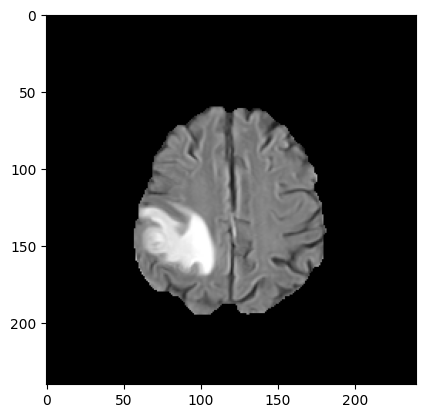

In [33]:
leasions, leasion_layers = load_2d_image(
    patient_id = "sub-01134825",
    path_to_sliced_images = path_to_sliced_images,
    include_mask = True,
    only_cutout = False,
    save_as_rgb = True
)

#print(leasions[0].shape)

plt.imshow(leasions[0][3], cmap = "gray")

print(leasions[0][1].shape)

merged = merge_2d_rgb_images(leasions)

#merged = merge_2d_rgb_images(leasions)
# plt.imshow(merged[0][:,:,2], cmap = "gray")

#### Data Augmentation

custom layer that adjusts all pixel values to be between 0 and 1

In [44]:
class NormalizeToRange(tf.keras.layers.Layer):
    def __init__(self, zero_to_one=True):
        super(NormalizeToRange, self).__init__()
        self.zero_to_one = zero_to_one

    def call(self, inputs):
        min_val = tf.reduce_min(inputs)
        max_val = tf.reduce_max(inputs)
        if self.zero_to_one:
            # Normalize to [0, 1]
            normalized = (inputs - min_val) / (max_val - min_val)
        else:
            # Normalize to [-1, 1]
            normalized = 2 * (inputs - min_val) / (max_val - min_val) - 1
        return normalized

Random Rescaling Custom Layer

In [43]:
class RandomRescale(tf.keras.layers.Layer):
    def __init__(self, scale_range=(0.8, 1.2), **kwargs):
        """
        Custom layer for random rescaling of images.
        Args:
            scale_range (tuple): A tuple specifying the minimum and maximum scaling factors.
                                 Values < 1.0 zoom out, and > 1.0 zoom in.
        """
        super(RandomRescale, self).__init__(**kwargs)
        self.scale_range = scale_range

    def call(self, inputs, training=None):
        if training:
            # Randomly choose a scaling factor
            scale = tf.random.uniform([], self.scale_range[0], self.scale_range[1])
            
            # Get image dimensions
            input_shape = tf.shape(inputs)
            #height, width = input_shape[1], input_shape[2]
            height, width = input_shape[0], input_shape[1]
            
            # Compute new dimensions
            new_height = tf.cast(tf.cast(height, tf.float32) * scale, tf.int32)
            new_width = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)
            
            # Resize image to new dimensions
            scaled_image = tf.image.resize(inputs, [new_height, new_width])
            
            # Crop or pad to original size
            scaled_image = tf.image.resize_with_crop_or_pad(scaled_image, height, width)
            
            return scaled_image
        else:
            return inputs

    def get_config(self):
        config = super(RandomRescale, self).get_config()
        config.update({"scale_range": self.scale_range})
        return config


a simple data augmentation protocol that includes
- horizontal flip
- rescaling to 0 - 1
- random contrast
- random brightness
- random rotation
- rescaling again lol
- random translatio

I had to rescale the images again using a custom layer, so that all images values are between 0 and 1 in the end

input shape: (240, 240, 5)
augmented shape: (240, 240, 5)
Max value: 1.0
Mean value: 0.17090787
Min value: 0.0


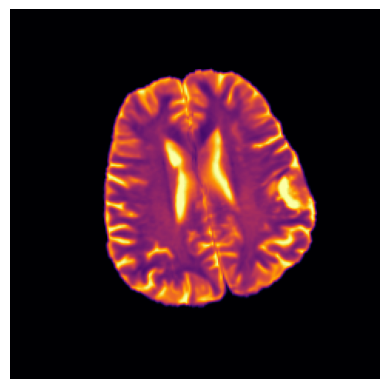

In [ ]:
patient_images = merge_2d_images(
    load_2d_image(
        patient_id = "sub-01921604",
        path_to_sliced_images = path_to_sliced_images,
        include_mask = True,
        only_cutout = False
        )[0]
    )[1]
print(f"input shape: {patient_images.shape}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    #tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4)), #, value_range=(0, 1)
    tf.keras.layers.RandomRotation(factor = (-0.14, 0.14), fill_mode = "nearest"),
    NormalizeToRange(zero_to_one=True),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest"
    ),
    RandomRescale(scale_range=(0.7, 1.2))
])

#consider adding some noise

augmented_images = data_augmentation(patient_images)

print(f"augmented shape: {augmented_images.shape}")

plt.imshow(np.array(augmented_images[:,:,2]), cmap="gray")
plt.axis("off")

print("Max value:", np.array(augmented_images).max())
print("Mean value:", np.array(augmented_images).mean())
print("Min value:", np.array(augmented_images).min())

#### Class weight calculation for weighted loss

In [ ]:
# Insert this as a new code cell (e.g., Cell 30)

print("--- Calculating Lesion-Level Label Distribution ---")

# Ensure prerequisite variables and functions are available
if 'specific_primaries_dict' not in locals() or 'patient_ids' not in locals():
    raise NameError("ERROR: 'specific_primaries_dict' or 'patient_ids' is not defined. "
                    "Please run the notebook cells that define these variables first (Cells 13 & 17).")
if 'load_2d_rgb_image' not in locals():
    raise NameError("ERROR: 'load_2d_rgb_image' function is not defined (Cell 20).")
if 'path_to_sliced_images' not in locals():
    raise NameError("ERROR: 'path_to_sliced_images' is not defined (Cell 19).")


all_lesion_labels = []
# Get a list of patient subfolders actually present in path_to_sliced_images
available_sliced_patients = [p for p in os.listdir(path_to_sliced_images) if os.path.isdir(os.path.join(path_to_sliced_images, p))]

# Filter patient_ids to only include those present in both path_to_sliced_images AND specific_primaries_dict
valid_patient_ids_for_lesion_count = [
    pid for pid in patient_ids
    if pid in available_sliced_patients and pid in specific_primaries_dict
]

# Report any discrepancies
missing_in_slices = set(patient_ids) - set(available_sliced_patients)
if missing_in_slices:
    print(f"Warning: The following patients from 'patient_ids' are not in 'path_to_sliced_images' and will be skipped: {missing_in_slices}")

missing_in_dict = set(patient_ids) - set(specific_primaries_dict.keys())
if missing_in_dict:
     print(f"Warning: The following patients from 'patient_ids' are not in 'specific_primaries_dict' and will be skipped: {missing_in_dict}")


for pat_id in tqdm(valid_patient_ids_for_lesion_count, desc="Counting lesions per patient"):
    try:
        # The parameters include_mask, only_cutout, save_as_rgb for load_2d_rgb_image
        # should not affect the *number* of lesions found.
        # We use include_mask=True as it's used in the TFRecord creation logic (Cell 22)
        # and save_as_rgb=False as the base image loading is typically grayscale before potential RGB stacking.
        lesions_data, _ = load_2d_image(
            patient_id=pat_id,
            path_to_sliced_images=path_to_sliced_images,
            include_mask=True,
            only_cutout=False,
            save_as_rgb=False
        )
        num_lesions_for_patient = len(lesions_data)
        
        if num_lesions_for_patient == 0:
            print(f"Warning: Patient {pat_id} has 0 lesions. Skipping.")
            continue
            
        primary_class_for_patient = specific_primaries_dict[pat_id]
        all_lesion_labels.extend([primary_class_for_patient] * num_lesions_for_patient)
        
    except FileNotFoundError:
        print(f"Warning: Sliced image data not found for patient {pat_id} in {path_to_sliced_images / pat_id}. Skipping this patient.")
    except Exception as e:
        print(f"Error processing patient {pat_id}: {e}. Skipping this patient.")

# This series now represents the primary class (0-5) for each individual lesion
lesion_labels_in_tfrecord_series = pd.Series(all_lesion_labels)

print("\nLesion-Level Label Distribution (0-5 classes, as would be in TFRecords):")
if not lesion_labels_in_tfrecord_series.empty:
    print(lesion_labels_in_tfrecord_series.value_counts().sort_index())
    print(f"Total number of lesions processed: {len(all_lesion_labels)}")
else:
    print("No lesion labels were generated. Please check patient data and paths.")

print("--- Finished Calculating Lesion-Level Label Distribution ---")

--- Calculating Lesion-Level Label Distribution ---


Counting lesions per patient:  23%|██▎       | 106/470 [00:01<00:06, 58.20it/s]

Counting lesions per patient:  34%|███▎      | 158/470 [00:02<00:03, 88.96it/s]

Counting lesions per patient:  42%|████▏     | 199/470 [00:02<00:02, 103.75it/s]

Counting lesions per patient:  49%|████▊     | 229/470 [00:02<00:02, 119.52it/s]

Counting lesions per patient:  62%|██████▏   | 293/470 [00:03<00:01, 124.83it/s]

Counting lesions per patient:  65%|██████▌   | 307/470 [00:03<00:01, 90.65it/s] 

Counting lesions per patient:  91%|█████████▏| 430/470 [00:04<00:00, 139.73it/s]

Counting lesions per patient: 100%|██████████| 470/470 [00:05<00:00, 93.84it/s] 


Lesion-Level Label Distribution (0-5 classes, as would be in TFRecords):
0     92
1    973
2    310
3    271
4     99
5     80
Name: count, dtype: int64
Total number of lesions processed: 1825
--- Finished Calculating Lesion-Level Label Distribution ---


In [12]:
# --- Class Weight Calculation Block (Simulating Training Script Parsing - LESION-BASED) ---

# IMPORTANT: Ensure this block runs *after* the cell that defines
# 'lesion_labels_in_tfrecord_series' (the new block created in Step 2)

print("--- Calculating Class Weights Based on Lesion Counts (Simulating Training Script Parsing) ---")

# Check if lesion_labels_in_tfrecord_series exists
if 'lesion_labels_in_tfrecord_series' not in locals() or lesion_labels_in_tfrecord_series.empty:
    raise NameError("ERROR: 'lesion_labels_in_tfrecord_series' is not defined or is empty. "
                    "Please run the new block that calculates lesion-level labels before this block.")

# 1. Use the base 6-class labels FOR EACH LESION (0-5)
print("\nBase Lesion-Level Label Distribution (used for TFRecords):")
print(lesion_labels_in_tfrecord_series.value_counts().sort_index())

# 2. Dictionary to store the weights for each training scenario (2-6 classes)
all_scenario_class_weights_lesion_based = {}

# 3. Loop through the possible 'num_classes' settings in the training script
for n_classes_scenario in range(2, 7): # n_classes_scenario is num_classes used during training (2, 3, 4, 5, 6)
    print(f"\n--- Simulating for num_classes = {n_classes_scenario} in training script (Lesion-Based) ---")

    # Simulate the label collapsing that would happen during training script's parse_record
    def simulate_parsing_for_lesions(label, target_n_classes):
        # In your training script, class 0 is 'other'.
        # Classes 1 to target_n_classes-1 are the specific primaries.
        # Any original label >= target_n_classes becomes 'other' (class 0).
        # Label 0 (original 'other') remains 'other' (class 0).
        if 1 <= label < target_n_classes:
            return label  # Specific primary class
        else:
            return 0      # 'Other' class

    # Apply the simulation function to the base lesion labels
    labels_after_parsing_series_lesion_based = lesion_labels_in_tfrecord_series.apply(
        lambda x: simulate_parsing_for_lesions(x, n_classes_scenario)
    )

    print(f"Lesion-Level Label Distribution *After* Simulated Parsing (num_classes={n_classes_scenario}):")
    print(labels_after_parsing_series_lesion_based.value_counts().sort_index())

    # Determine the unique classes present AFTER simulated parsing
    unique_parsed_classes_lesion_based = np.sort(labels_after_parsing_series_lesion_based.unique())
    print(f"Unique classes present after simulation (Lesion-Based): {unique_parsed_classes_lesion_based}")
    
    expected_classes_in_scenario = np.arange(n_classes_scenario)
    
    # Check for missing classes and handle warnings
    current_counts = labels_after_parsing_series_lesion_based.value_counts()
    for cls_val in expected_classes_in_scenario:
        if cls_val not in current_counts.index:
            print(f"Warning: Class {cls_val} has 0 lesions after simulating for num_classes={n_classes_scenario}. "
                  "It will be handled by class_weight='balanced' if other classes exist.")

    weights_dict_lesion_based = {}
    if len(unique_parsed_classes_lesion_based) == 0:
        print(f"Warning: No classes present after simulating for num_classes={n_classes_scenario}. Skipping weight calculation.")
    elif len(unique_parsed_classes_lesion_based) == 1:
        # If only one class remains (e.g., all are 'other'), its weight is 1.0
        weights_dict_lesion_based = {unique_parsed_classes_lesion_based[0]: 1.0}
        print(f"Warning: Only one class present after simulating for num_classes={n_classes_scenario}. Assigning weight of 1.0.")
    else:
        # Calculate weights using sklearn based on the lesion labels *after* simulated parsing
        weights = class_weight.compute_class_weight(
            class_weight="balanced",
            classes=unique_parsed_classes_lesion_based, # Use the classes actually present in the data
            y=labels_after_parsing_series_lesion_based.to_numpy()
        )
        # Store weights in a dictionary format {class_label: weight}
        weights_dict_lesion_based = {label: weight for label, weight in zip(unique_parsed_classes_lesion_based, weights)}

    all_scenario_class_weights_lesion_based[n_classes_scenario] = weights_dict_lesion_based
    print(f"Class Weights (Lesion-Based, for training with num_classes={n_classes_scenario}): {weights_dict_lesion_based}")

print("\n--- Finished Simulating and Calculating Lesion-Based Class Weights ---")
# 'all_scenario_class_weights_lesion_based' now holds the correctly calculated weights.
# Example: all_scenario_class_weights_lesion_based[2] has weights for {0: ..., 1: ...} for the 2-class case.

--- Calculating Class Weights Based on Lesion Counts (Simulating Training Script Parsing) ---

Base Lesion-Level Label Distribution (used for TFRecords):
0     92
1    973
2    310
3    271
4     99
5     80
Name: count, dtype: int64

--- Simulating for num_classes = 2 in training script (Lesion-Based) ---
Lesion-Level Label Distribution *After* Simulated Parsing (num_classes=2):
0    852
1    973
Name: count, dtype: int64
Unique classes present after simulation (Lesion-Based): [0 1]
Class Weights (Lesion-Based, for training with num_classes=2): {0: 1.0710093896713615, 1: 0.9378211716341213}

--- Simulating for num_classes = 3 in training script (Lesion-Based) ---
Lesion-Level Label Distribution *After* Simulated Parsing (num_classes=3):
0    542
1    973
2    310
Name: count, dtype: int64
Unique classes present after simulation (Lesion-Based): [0 1 2]
Class Weights (Lesion-Based, for training with num_classes=3): {0: 1.1223862238622386, 1: 0.6252141144227475, 2: 1.9623655913978495}

-

Rough Pretraining Class Weights

brain_tumor_dataset

In [ ]:
# Glioma = 0 - n(1426)
# Meningioma = 1 - n(708)
# Pituitary = 2 - n(930)

counts = {
    0: 1426,
    1: 708,
    2: 930
}

total_samples = sum(counts.values())
num_classes = len(counts)

#Calculate the class weights for each class
rough_class_weights = {}
for class_label, class_count in counts.items():
    rough_class_weights[class_label] = total_samples / (num_classes * class_count)

print(rough_class_weights)

{0: 0.7162225338943432, 1: 1.4425612052730696, 2: 1.0982078853046595}


Fine Pretraining Class Weights

In [3]:
# Glioblastoma = 0 - n(861)
# Astrocytoma (IDH-wildtype) = 1 - n(35)
# Astrocytoma (IDH-mutant) = 2 - n(133)
# Oligodendroglioma = 3 - n(55)
# Metastases = 4 - n(4063)

counts = {
    0: 861,
    1: 35,
    2: 133,
    3: 55,
    4: 4063
}

total_samples = sum(counts.values())
num_classes = len(counts)

# Calculate the class weights for each of the 5 class
fine_5_class_weights = {}
for class_label, class_count in counts.items():
    fine_5_class_weights[class_label] = total_samples / (num_classes * class_count)

print("Fine 5 Class Weights:")
print(fine_5_class_weights)
print()

# Combine classes 0 to 3 into one class and calculate the class weights
combined_class_counts = counts[0] + counts[1] + counts[2] + counts[3]
combined_num_classes = 2
combined_class_weight = total_samples / (combined_num_classes * combined_class_counts)
mets_class_weight = total_samples / (combined_num_classes * counts[4])

print("Fine combined class weights")
print(f"combined class weight: {combined_class_weight}, mets class weight: {mets_class_weight}") # combined_class_weight)

Fine 5 Class Weights:
{0: 1.1955865272938444, 1: 29.411428571428573, 2: 7.739849624060151, 3: 18.716363636363635, 4: 0.25335958651242924}

Fine combined class weights
combined class weight: 2.3740774907749076, mets class weight: 0.6333989662810731


#### TFRecord Creation

In [ ]:
path_to_derivatives = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords")
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")

tf.experimental.numpy.experimental_enable_numpy_behavior()

def serialize_2d_patient(image_data, sex, age, layer, primary):

    #print(image_data.shape)

    #image_data = prepare_2d_rgb_images(patientID, include_mask = True, only_cutout = False)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value = image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value = [sex])),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value = [age])),
                'layer': tf.train.Feature(int64_list=tf.train.Int64List(value = [layer])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value= [primary])),
            }   
        )
    )

    return patient_example.SerializeToString()

# consider addng include_mask as parameter
def writeTFRecordFiles(save_as_rgb, save_as_cutout, include_mask, only_one_patient = False):
    # Write the dataset to TFRecord
    options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

    patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

    # write a check to compare patient_ids with patients
    patients = set(patients).intersection(patient_ids)

    slice_text = "cutout" if save_as_cutout else "slice"
    color_text = "rgb" if save_as_rgb else "gray"

    folder_text = f"all_pats_single_{slice_text}_{color_text}"

    path_to_all_tfr = path_to_derivatives / Path(folder_text)

    os.makedirs(path_to_all_tfr, exist_ok=True)

    # get list of already processed patients
    tfr_already_created_patients = [patient for patient in os.listdir(path_to_all_tfr) if os.path.isdir(os.path.join(path_to_all_tfr, patient))]

    for patient in tfr_already_created_patients:
        # check if the number of leasions equals the number of tfr files
        path_to_patient = path_to_all_tfr / patient
        tfr_files = [f for f in os.listdir(path_to_patient) if f.endswith(".tfrecord")]
        num_leasions = len(tfr_files)
        leasions, leasion_layers = prepare_2d_images(patient, include_mask = include_mask, only_cutout = save_as_cutout, save_as_rgb=save_as_rgb)
        if num_leasions != len(leasions):
            # delete the patient folder
            shutil.rmtree(path_to_patient)
            tfr_already_created_patients.remove(patient)
    
    counter = 0

    # loop through patients
    for pat in tqdm(patients):

        if counter > 0 and only_one_patient:
            break

        if os.path.exists(path_to_all_tfr):
            if pat in tfr_already_created_patients:
                print(f"Skipping patient {pat}")
                continue

        # create patient folder
        path_to_patient = path_to_all_tfr / pat
        os.makedirs(path_to_patient, exist_ok=False)

        leasions, leasion_layers = prepare_2d_images(pat, include_mask = include_mask, only_cutout = save_as_cutout, save_as_rgb = save_as_rgb)
        print(f"found {len(leasions)} leasion(s) and {len(leasion_layers)} layers in patient {pat}")

        for i in range(len(leasions)):

            file_path = str(path_to_patient) + "/" + pat + "_" + str(i) + ".tfrecord"
            with tf.io.TFRecordWriter(file_path, options) as writer:

                sex = sex_array_dict[pat]
                leasion_data = leasions[i]
                age = int(list(training_patients[training_patients["participant_id"] == pat]["age"])[0])
                layer = leasion_layers[i]
                primary = specific_primaries_dict[pat]
                # print("________________")
                # print(age)
                example = serialize_2d_patient(leasion_data, sex, age, layer, primary)
                writer.write(example)
        
        counter += 1

In [ ]:
writeTFRecordFiles(save_as_rgb = False, save_as_cutout = False, include_mask = True)

In [ ]:
writeTFRecordFiles(save_as_rgb = True, save_as_cutout = False, include_mask = True)

In [ ]:
writeTFRecordFiles(save_as_rgb = False, save_as_cutout = True)

In [ ]:
writeTFRecordFiles(save_as_rgb = True, save_as_cutout = True)

#### Read TFRecord File

Sex: 1
Age: 47
Layer: 53
Primary: 1
(240, 240, 5)
Median value: 0.0


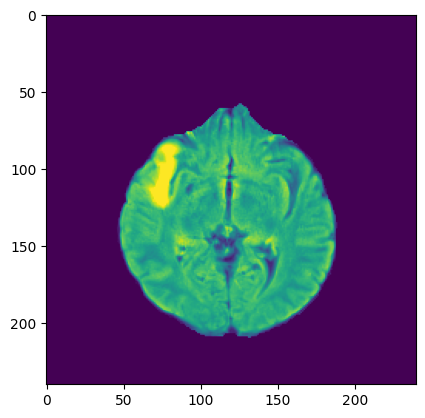

In [30]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-01190670/sub-01190670_1.tfrecord"
rgb = False

num_images = 5 # 4 sequences + 1 mask

image_shape = []

if rgb: # rgb images need three channels
    image_shape = [240, 240, 3, num_images]
else: # gray scale images don't
    image_shape = [240, 240, num_images]

feature_description = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "sex": tf.io.FixedLenFeature([], tf.int64, default_value=[0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "layer": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, image_shape) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["layer"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, layer, primary in test_image:
    print(f"Sex: {sex.numpy()}")
    print(f"Age: {age.numpy()}")
    print(f"Layer: {layer.numpy()}")
    print(f"Primary: {primary.numpy()}")
    numpy_image = image.numpy()
    print(numpy_image.shape)
    # print max and min values
    print(f"Median value: {np.median(numpy_image)}")
    plt.imshow(numpy_image[:,:,3])

# sex
# m = 1, 0
# f = 0, 1

#### Get Min-Max of Age and Layer Number
Iterate over all patients to get the minimum and maximum value of the age and the layer number. This is important to normalize the values before training.

In [ ]:
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")

def get_min_max_age_layer():

    patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

    # write a check to compare patient_ids with patients
    patients = set(patients).intersection(patient_ids)

    ages = []
    layers = []
    
    # loop through patients
    for pat in tqdm(patients):

        leasions, leasion_layers = prepare_2d_images(pat, include_mask = False, only_cutout = False, save_as_rgb=False)

        for i in range(len(leasions)):

            age = int(list(training_patients[training_patients["participant_id"] == pat]["age"])[0])
            ages.append(age)

            layer = leasion_layers[i]
            layers.append(layer)
    
    return min(ages), max(ages), min(layers), max(layers)

In [15]:
min_age, max_age, min_layer, max_layer = get_min_max_age_layer()

print(f"Min age: {min_age}, Max age: {max_age}, Min layer: {min_layer}, Max layer: {max_layer}")

100%|██████████| 470/470 [00:02<00:00, 168.35it/s]

Min age: 25, Max age: 93, Min layer: 0, Max layer: 138


### Dataset Visualisation

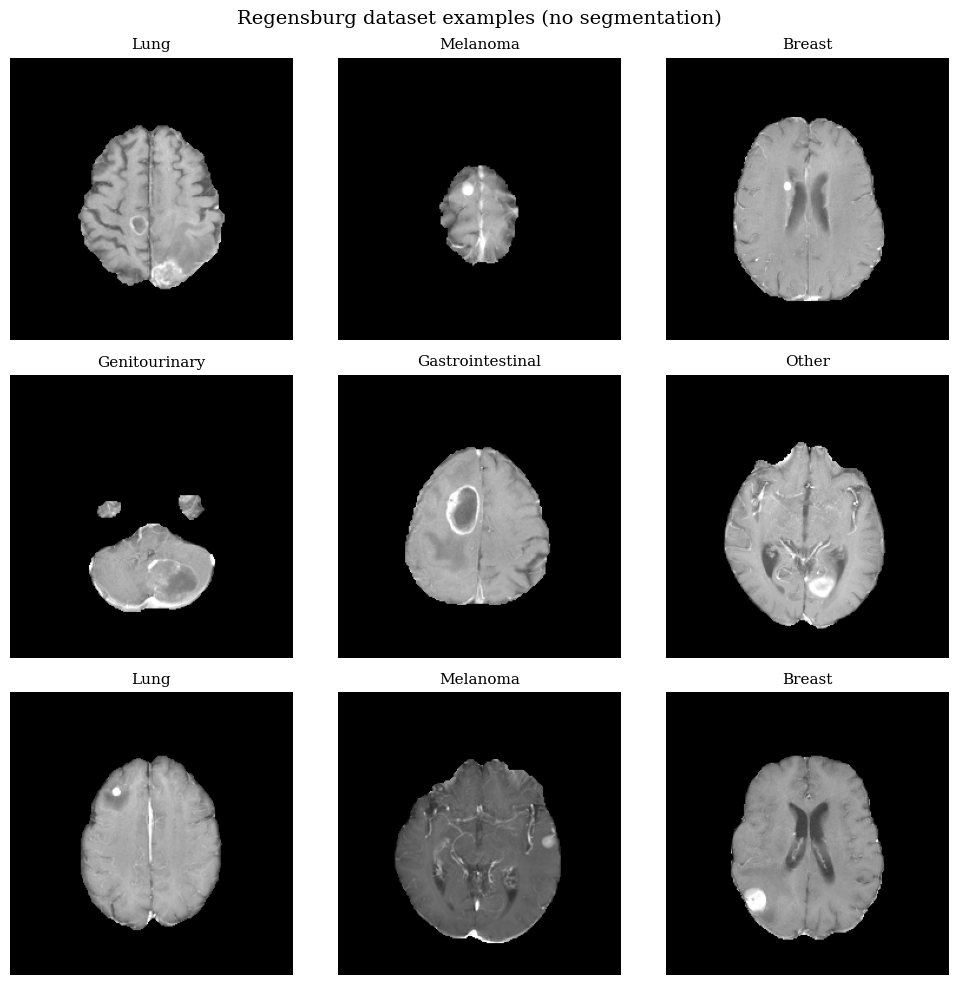

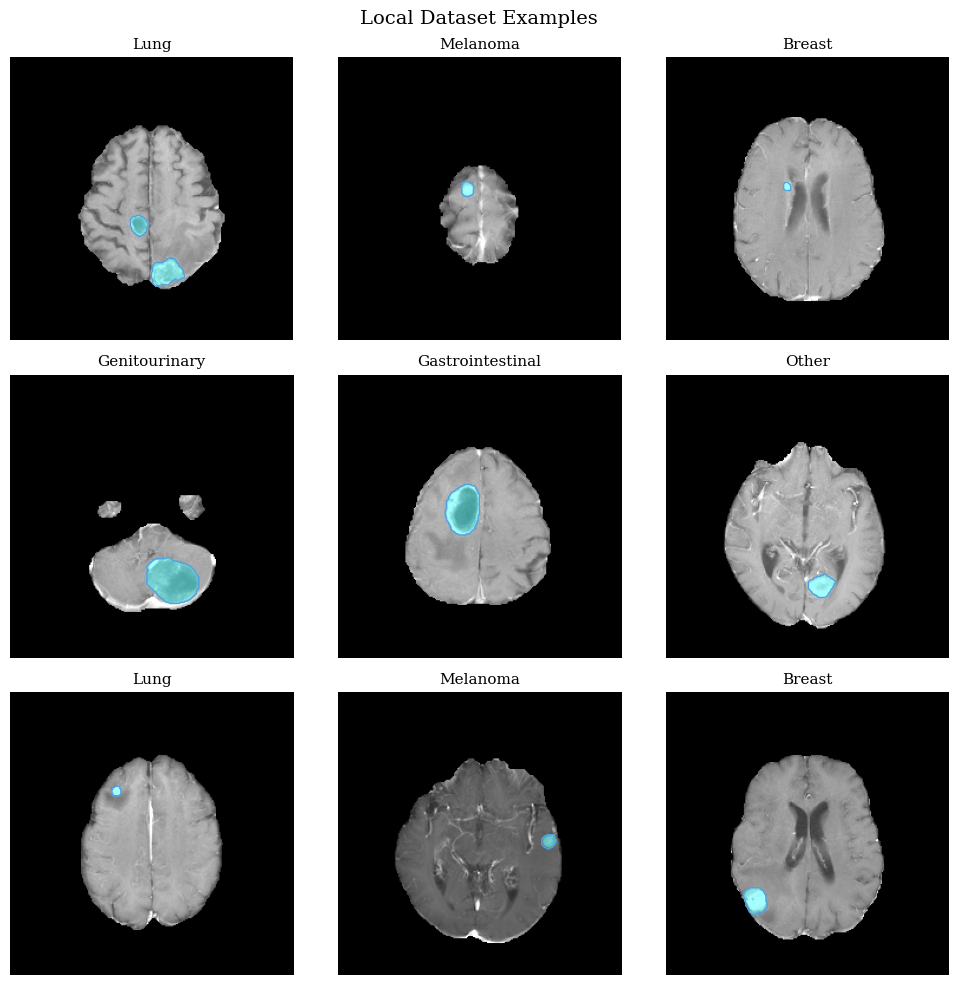

In [58]:
import os
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# -----------------------------
# 0) Configure these two things
# -----------------------------
# TFRecord root folder that contains sub-*/sub-*_X.tfrecord
PATH_TO_REGENSBURG_TFR_ROOT = Path(
    "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray"
)

# Your stacked channels are (4 sequences + 1 mask) = 5.
# Set which index is T1c in your stack.
# Common choices:
#   [T1, T1c, T2, FLAIR, MASK]  -> T1C_INDEX = 1, MASK_INDEX = 4
#   [T1, T2, FLAIR, T1c, MASK]  -> T1C_INDEX = 3, MASK_INDEX = 4   (your quick test plotted [:,:,3])
T1C_INDEX  = 1
MASK_INDEX = 4


# -----------------------------
# 1) Class name mapping (local)
# -----------------------------
# Your return_specific_primaries_dict(...,[1,2,3,4,5],"Regensburg") produces 1..5 (+ 0 for "other")
reg_label_to_name = {
    0: "Other",
    1: "Lung",
    2: "Melanoma",
    3: "Breast",
    4: "Genitourinary",
    5: "Gastrointestinal",
}

def label_to_text(lbl: int) -> str:
    return reg_label_to_name.get(int(lbl), "Unknown")


# -----------------------------
# 2) TFRecord parsing
# -----------------------------
# Use your image_shape logic (grayscale case)
image_shape = [240, 240, 5]

feature_description_reg = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "sex": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "layer": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse_reg_example(serialized):
    ex = tf.io.parse_single_example(serialized, feature_description_reg)
    img = tf.reshape(ex["image"], image_shape)
    return img, ex["primary"]


def read_one_tfrecord_example(tfr_path: Path):
    """Reads exactly one example from a TFRecord file (your files should contain 1 example)."""
    ds = tf.data.TFRecordDataset([str(tfr_path)], compression_type="GZIP").map(parse_reg_example).take(1)
    for img, y in ds:
        return img.numpy(), int(y.numpy())
    return None, None


# -----------------------------
# 3) Utilities: pick T1c + mask
# -----------------------------
def pick_t1c(img_stack: np.ndarray) -> np.ndarray:
    img_stack = np.asarray(img_stack)
    if img_stack.ndim != 3:
        return np.squeeze(img_stack)
    idx = min(T1C_INDEX, img_stack.shape[-1] - 1)
    return img_stack[..., idx]

def pick_mask(img_stack: np.ndarray) -> np.ndarray:
    img_stack = np.asarray(img_stack)
    if img_stack.ndim != 3:
        return None
    if img_stack.shape[-1] <= MASK_INDEX:
        return None
    m = img_stack[..., MASK_INDEX]
    m = (m > 0).astype(np.uint8)
    return m


# -----------------------------
# 4) Sampling: >=1 per class, unique patient
# -----------------------------
def collect_patient_tfrecords(tfr_root: Path):
    """
    Returns dict: patient_id -> list[Path to tfrecord files]
    Assumes folder structure: tfr_root/sub-XXXXX/*.tfrecord
    """
    patient_to_files = {}
    for patient_dir in sorted(tfr_root.glob("sub-*")):
        if not patient_dir.is_dir():
            continue
        files = sorted(patient_dir.glob("*.tfrecord"))
        if files:
            patient_to_files[patient_dir.name] = files
    return patient_to_files


def sample_regensburg_examples_one_per_primary_unique_patient(
    n=9,
    seed=42,
    tfr_root: Path = PATH_TO_REGENSBURG_TFR_ROOT,
):
    """
    - Ensures no patient appears more than once.
    - Ensures at least one example per primary class (as far as n allows).
    - Chooses one TFRecord per patient (random among that patient's lesions).
    """
    rng = random.Random(seed)

    patient_to_files = collect_patient_tfrecords(tfr_root)
    patients = list(patient_to_files.keys())
    rng.shuffle(patients)

    # First pass: get each patient's primary by reading ONE random tfrecord (primary constant per patient)
    label_to_patients = defaultdict(list)
    patient_primary = {}

    for pid in patients:
        files = patient_to_files[pid]
        tfr = rng.choice(files)
        _, y = read_one_tfrecord_example(tfr)
        if y is None:
            continue
        patient_primary[pid] = y
        label_to_patients[y].append(pid)

    # Shuffle within each label group
    for y in label_to_patients:
        rng.shuffle(label_to_patients[y])

    # Prefer showing classes 1..5 first (and 0 last)
    preferred_label_order = [1, 2, 3, 4, 5, 0]
    label_order = [y for y in preferred_label_order if y in label_to_patients]
    label_order += [y for y in sorted(label_to_patients.keys()) if y not in label_order]

    selected_patients = []
    used_patients = set()

    # Step 1: one per label until full
    for y in label_order:
        if len(selected_patients) >= n:
            break
        if label_to_patients[y]:
            pid = label_to_patients[y].pop(0)
            if pid not in used_patients:
                selected_patients.append(pid)
                used_patients.add(pid)

    # Step 2: fill remaining slots round-robin
    while len(selected_patients) < n:
        added_any = False
        for y in label_order:
            if len(selected_patients) >= n:
                break
            if label_to_patients[y]:
                pid = label_to_patients[y].pop(0)
                if pid not in used_patients:
                    selected_patients.append(pid)
                    used_patients.add(pid)
                    added_any = True
        if not added_any:
            break

    # Build final examples by selecting one lesion tfrecord per selected patient
    examples = []
    for pid in selected_patients:
        tfr = rng.choice(patient_to_files[pid])
        img_stack, y = read_one_tfrecord_example(tfr)
        if img_stack is None:
            continue

        examples.append({
            "patient_id": pid,
            "y": y,
            "img_stack": img_stack,
            "tfr_path": str(tfr),
        })

        if len(examples) >= n:
            break

    return examples


# -----------------------------
# 5) Plotting: grayscale + blue overlay + blue border
# -----------------------------
def plot_grid_no_mask_regensburg(examples, suptitle="Regensburg examples (no segmentation)"):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, ex in zip(axes, examples):
        img2d = pick_t1c(ex["img_stack"])
        ax.imshow(img2d, cmap="gray")
        ax.set_title(label_to_text(ex["y"]), fontsize=11)
        ax.axis("off")

    for ax in axes[len(examples):]:
        ax.axis("off")

    plt.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_grid_with_mask_regensburg(examples, suptitle="Regensburg examples (segmentation highlighted)"):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, ex in zip(axes, examples):
        img2d = pick_t1c(ex["img_stack"])
        ax.imshow(img2d, cmap="gray")

        m = pick_mask(ex["img_stack"])
        if m is not None and m.sum() > 0:
            # light blue fill only inside mask
            ax.imshow(np.ma.masked_where(m == 0, m), cmap="cool", alpha=0.35)
            # crisp border
            ax.contour(m, levels=[0.5], colors=["#4FA3E3"], linewidths=1.0)

        ax.set_title(label_to_text(ex["y"]), fontsize=11)
        ax.axis("off")

    for ax in axes[len(examples):]:
        ax.axis("off")

    plt.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 6) Run
# -----------------------------
examples_reg = sample_regensburg_examples_one_per_primary_unique_patient(n=9, seed=48)

plot_grid_no_mask_regensburg(examples_reg, suptitle="Regensburg dataset examples (no segmentation)")
plot_grid_with_mask_regensburg(examples_reg, suptitle="Local Dataset Examples")


### Lesion summary

## Yale Dataset
Source: https://doi.org/10.7937/6be1-r748

In [6]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

from sklearn.utils import class_weight

import sys
sys.path.append(r"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification")

import brain_mets_classification.custom_funcs as funcs

from tqdm import tqdm

import shutil

import imageio
import cv2

In [2]:
path_to_yale_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_dataset_normalized")
path_to_yale_met_slices = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_metastases")
path_to_yale_excel = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/Pretreat-MetsToBrain-Masks_clin_20240410.xlsx")
path_to_yale_tfrecords = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_slices_tfrecords')

In [7]:
yale_training_patients = pd.read_excel(path_to_yale_excel, sheet_name="Data")

yale_patient_ids = yale_training_patients["BraTS_MET_ID"].tolist()
print(yale_patient_ids)
print(f"Total amount: {len(yale_training_patients)}")

# preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

# for patient in preprocessed_patients:
#     if patient not in patient_ids:
#         print(patient)

[86, 89, 90, 96, 97, 98, 100, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 258, 260, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 309, 310]
Total

In [8]:
# adjust the ids of the yale_primaries_array_dict to match the folder names
# right now the ids are like this: 86, 89, etc.
# I need them to be 00086, 00089, etc.

def fill_keys_to_five_letters(dictionary):
    """Fills the keys of a dictionary with leading zeros to make them 5 characters long.
    Ars: dictionary: A dictionary with keys that need to be padded.
    Returns: A dictionary with keys that are 5 characters long.
    """
    for key in list(dictionary.keys()):
        new_key = str(key).zfill(5)  # Pad the key with zeros to make it 5 digits
        dictionary[new_key] = dictionary.pop(key)
    
    return dictionary

### Unify primary classes

count different primaries that exist within the Yale Dataset. As one can see, most primaries belong to lung cancer (86 + 17 = 103), after that Melanoma (41), then Breast Cancer (26), Renal cell carcinoma (16) and lastly Gastrointestinal cancers (16).

In [9]:
# primaries are written like this: 1, 2, 3, 4, 5
# explanation:
# 1 = Breast cancer; 2 = Gastrointestinal cancers;
# 3 = Small cell lung cancer; 4 = Melanoma;
# 5 = Non small cell lung cancer; 6 = Renal cell carcinoma; 7 = Other

# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
yale_primaries_array = yale_training_patients["Primary"]
print(yale_primaries_array.value_counts())

Primary
5    86
4    41
1    26
3    17
6    16
2    14
Name: count, dtype: int64


Next we'll merge the two lung categories into one, meaning we combine category number 3 and category number 5 and turn it into a new category, 0.

In [10]:
# replace each 5 and 3 in the yale_primaries_array with a 0

yale_primaries_array = yale_primaries_array.replace(5, 0)
yale_primaries_array = yale_primaries_array.replace(3, 0)

print(yale_primaries_array.value_counts())

Primary
0    103
4     41
1     26
6     16
2     14
Name: count, dtype: int64


In [14]:
yale_primaries_array_dict = pd.Series(yale_primaries_array.values, index=yale_training_patients.BraTS_MET_ID).to_dict()

print("Original Yale Primaries Dict:")
print(yale_primaries_array_dict)
print()

# adjust the ids of the yale_primaries_array_dict to match the folder names
# right now the ids are like this: 86, 89, etc.
# I need them to be 00086, 00089, etc.
yale_primaries_array_dict = fill_keys_to_five_letters(yale_primaries_array_dict)

print("Adjusted Yale Primaries Dict:")
print(yale_primaries_array_dict)
print()

print("Return Specific Primaries Dict Function output:")
yale_specific_primaries_dict = return_specific_primaries_dict(yale_primaries_array_dict, [1,2,3,4,5], "Yale")

print(pd.Series(yale_specific_primaries_dict.values()).value_counts())

Original Yale Primaries Dict:
{86: 1, 89: 4, 90: 6, 96: 0, 97: 0, 98: 6, 100: 4, 102: 1, 104: 2, 105: 0, 106: 0, 107: 6, 108: 6, 109: 4, 110: 6, 111: 0, 112: 6, 113: 1, 114: 4, 115: 4, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 1, 122: 0, 123: 0, 124: 4, 125: 6, 126: 0, 127: 4, 128: 2, 129: 2, 130: 1, 131: 0, 132: 0, 133: 6, 134: 0, 135: 0, 136: 1, 137: 1, 138: 4, 139: 1, 140: 0, 141: 2, 142: 1, 143: 4, 144: 0, 145: 0, 147: 1, 148: 0, 149: 0, 150: 6, 151: 0, 152: 0, 153: 0, 154: 0, 155: 0, 156: 6, 157: 4, 158: 4, 159: 4, 160: 0, 161: 4, 162: 0, 163: 0, 164: 0, 165: 0, 166: 4, 167: 6, 169: 4, 170: 0, 171: 0, 172: 0, 173: 2, 174: 4, 175: 0, 176: 0, 177: 0, 178: 0, 179: 0, 180: 0, 181: 0, 182: 6, 183: 0, 184: 0, 185: 4, 187: 4, 188: 2, 189: 0, 190: 4, 191: 2, 192: 0, 193: 0, 194: 1, 195: 0, 196: 1, 197: 0, 198: 4, 199: 0, 200: 1, 201: 2, 202: 4, 203: 4, 204: 4, 205: 4, 206: 1, 207: 0, 208: 2, 209: 0, 210: 1, 211: 0, 212: 0, 213: 0, 214: 0, 215: 0, 216: 0, 217: 1, 219: 1, 220: 6, 221: 0,

For clarification:
1 : Lung cancer
2 : Melanoma
3 : Breast cancer
4 : Renal cell cancer
5 : Gastrointestinal cancer

### One hot encode sex
The sex in the yale dataset is encoded as such:\
0 = Male; 1 = Female\
Then it's time to adjust the dataset accordingly:

In [25]:
yale_sex_array_dict = pd.Series(yale_training_patients["Sex"].values, index=yale_training_patients.BraTS_MET_ID).to_dict()

yale_sex_array_dict = fill_keys_to_five_letters(yale_sex_array_dict)
print(yale_sex_array_dict)
print(pd.Series(yale_sex_array_dict).value_counts())

{'00086': 1, '00089': 1, '00090': 1, '00096': 0, '00097': 1, '00098': 0, '00100': 1, '00102': 1, '00104': 1, '00105': 1, '00106': 1, '00107': 0, '00108': 0, '00109': 1, '00110': 1, '00111': 1, '00112': 0, '00113': 1, '00114': 0, '00115': 0, '00116': 1, '00117': 1, '00118': 1, '00119': 1, '00120': 1, '00121': 1, '00122': 1, '00123': 1, '00124': 0, '00125': 0, '00126': 1, '00127': 0, '00128': 0, '00129': 0, '00130': 1, '00131': 1, '00132': 0, '00133': 1, '00134': 0, '00135': 1, '00136': 1, '00137': 1, '00138': 0, '00139': 1, '00140': 0, '00141': 1, '00142': 1, '00143': 1, '00144': 0, '00145': 1, '00147': 1, '00148': 1, '00149': 0, '00150': 1, '00151': 1, '00152': 1, '00153': 1, '00154': 1, '00155': 1, '00156': 1, '00157': 1, '00158': 0, '00159': 0, '00160': 0, '00161': 1, '00162': 1, '00163': 1, '00164': 0, '00165': 0, '00166': 0, '00167': 0, '00169': 0, '00170': 1, '00171': 0, '00172': 1, '00173': 0, '00174': 1, '00175': 1, '00176': 1, '00177': 0, '00178': 1, '00179': 0, '00180': 1, '00

### 2D images

#### Prepare Images For Training
- load pngs files
- give options to load mask or cutout
- rotate images 90 degrees?
- compress all sequences into one array

(240, 240)


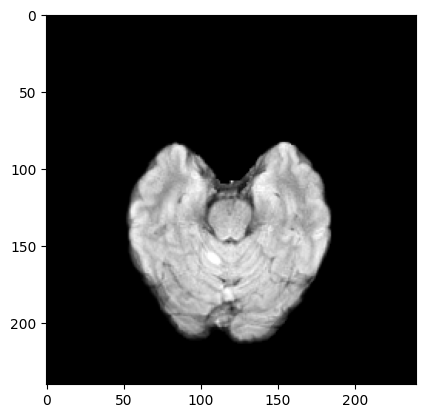

In [17]:
yale_test_leasions, yale_test_leasion_layers = load_2d_image(
    patient_id = "00086",
    path_to_sliced_images = path_to_yale_met_slices,
    dataset = "Yale",
    include_mask = True,
    only_cutout = False,
    save_as_rgb = False
)

plt.imshow(yale_test_leasions[0][3], cmap = "gray")

print(yale_test_leasions[0][1].shape)

merged = merge_2d_images(yale_test_leasions)

#### Data Augmentation

input shape: (240, 240, 5)
augmented shape: (240, 240, 5)
Max value: 1.0
Mean value: 0.12883793
Min value: 0.0


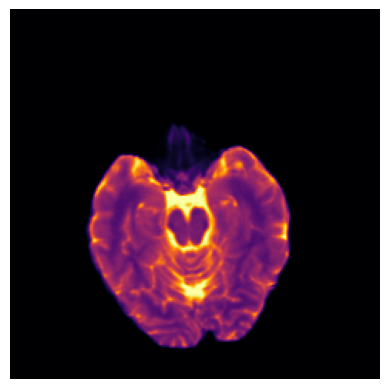

In [161]:
yale_patient_images = merge_2d_images(
    load_2d_image(
        patient_id = "00086",
        path_to_sliced_images = path_to_yale_met_slices,
        include_mask = True,
        only_cutout = False,
        save_as_rgb = False,
        dataset = "Yale"
    )[0])[1]

print(f"input shape: {yale_patient_images.shape}")

yale_augmented_images = data_augmentation(yale_patient_images)

print(f"augmented shape: {yale_augmented_images.shape}")

plt.imshow(np.array(yale_augmented_images[:,:,2]), cmap="inferno")
plt.axis("off")

print("Max value:", np.array(yale_augmented_images).max())
print("Mean value:", np.array(yale_augmented_images).mean())
print("Min value:", np.array(yale_augmented_images).min())

#### Class weight calculation for weighted loss

In [109]:
print("--- Calculating Lesion-Level Label Distribution ---")

# Ensure prerequisite variables and functions are available
if 'yale_specific_primaries_dict' not in locals() or 'yale_patient_ids' not in locals():
    raise NameError("ERROR: 'yale_specific_primaries_dict' or 'yale_patient_ids' is not defined. "
                    "Please run the notebook cells that define these variables first.")
if 'load_2d_image' not in locals():
    raise NameError("ERROR: 'load_2d_image' function is not defined (Cell 20).")
if 'merge_2d_images' not in locals():
    raise NameError("ERROR: 'merge_2d_images' function is not defined (Cell 21).")

# fill the yale_patient_ids to the correct length of 5 letters
# current ids: 86, 89, etc.
# correct ids: 00086, 00089, etc.
yale_patient_ids = [str(id).zfill(5) for id in yale_patient_ids]

all_lesion_labels = []
# Get a list of patient subfolders actually present in path_to_yale_met_slices
available_sliced_patients = [p for p in os.listdir(path_to_yale_met_slices) if os.path.isdir(os.path.join(path_to_yale_met_slices, p))]

# Filter patient_ids to only include those present in both path_to_yale_met_slices AND yale_specific_primaries_dict
valid_patient_ids_for_lesion_count = [
    pid for pid in yale_patient_ids
    if pid in available_sliced_patients and pid in yale_specific_primaries_dict
]

# Report any discrepancies
missing_in_slices = set(yale_patient_ids) - set(available_sliced_patients)
if missing_in_slices:
    print(f"Warning: The following patients from 'yale_patient_ids' are not in 'path_to_yale_met_slices' and will be skipped: {missing_in_slices}")

missing_in_dict = set(yale_patient_ids) - set(yale_specific_primaries_dict.keys())
if missing_in_dict:
     print(f"Warning: The following patients from 'yale_patient_ids' are not in 'yale_specific_primaries_dict' and will be skipped: {missing_in_dict}")


for pat_id in tqdm(valid_patient_ids_for_lesion_count, desc="Counting lesions per patient"):
    try:
        # The parameters include_mask, only_cutout, save_as_rgb for load_2d_rgb_image
        # should not affect the *number* of lesions found.
        # We use include_mask=True as it's used in the TFRecord creation logic (Cell 22)
        # and save_as_rgb=False as the base image loading is typically grayscale before potential RGB stacking.
        lesions_data, _ = load_2d_image(
            patient_id = pat_id,
            path_to_sliced_images = path_to_yale_met_slices,
            include_mask = True,
            only_cutout = False,
            save_as_rgb = False,
            dataset = "Yale"
        )
        num_lesions_for_patient = len(lesions_data)
        
        if num_lesions_for_patient == 0:
            print(f"Warning: Patient {pat_id} has 0 lesions. Skipping.")
            continue
            
        primary_class_for_patient = yale_specific_primaries_dict[pat_id]
        all_lesion_labels.extend([primary_class_for_patient] * num_lesions_for_patient)
        
    except FileNotFoundError:
        print(f"Warning: Sliced image data not found for patient {pat_id} in {path_to_yale_met_slices / pat_id}. Skipping this patient.")
    except Exception as e:
        print(f"Error processing patient {pat_id}: {e}. Skipping this patient.")

# This series now represents the primary class (0-5) for each individual lesion
yale_lesion_labels_in_tfrecord_series = pd.Series(all_lesion_labels)

print("\nLesion-Level Label Distribution (0-5 classes, as would be in TFRecords):")
if not yale_lesion_labels_in_tfrecord_series.empty:
    print(yale_lesion_labels_in_tfrecord_series.value_counts().sort_index())
    print(f"Total number of lesions processed: {len(all_lesion_labels)}")
else:
    print("No lesion labels were generated. Please check patient data and paths.")

print("--- Finished Calculating Lesion-Level Label Distribution ---")

--- Calculating Lesion-Level Label Distribution ---


Counting lesions per patient:  50%|████▉     | 99/200 [00:00<00:00, 114.17it/s]

Counting lesions per patient: 100%|██████████| 200/200 [00:01<00:00, 116.00it/s]


Lesion-Level Label Distribution (0-5 classes, as would be in TFRecords):
1    292
2    223
3    140
4     89
5     38
Name: count, dtype: int64
Total number of lesions processed: 782
--- Finished Calculating Lesion-Level Label Distribution ---


In [111]:
# --- Class Weight Calculation Block (Simulating Training Script Parsing - LESION-BASED) ---

# IMPORTANT: Ensure this block runs *after* the cell that defines
# 'yale_lesion_labels_in_tfrecord_series' (the new block created in Step 2)

print("--- Calculating Class Weights Based on Lesion Counts (Simulating Training Script Parsing) ---")

# Check if yale_lesion_labels_in_tfrecord_series exists
if 'yale_lesion_labels_in_tfrecord_series' not in locals() or yale_lesion_labels_in_tfrecord_series.empty:
    raise NameError("ERROR: 'yale_lesion_labels_in_tfrecord_series' is not defined or is empty. "
                    "Please run the new block that calculates lesion-level labels before this block.")

# 1. Use the base 6-class labels FOR EACH LESION (0-5)
print("\nBase Lesion-Level Label Distribution (used for TFRecords):")
print(yale_lesion_labels_in_tfrecord_series.value_counts().sort_index())

# 2. Dictionary to store the weights for each training scenario (2-6 classes)
all_scenario_class_weights_lesion_based = {}

# 3. Loop through the possible 'num_classes' settings in the training script
for n_classes_scenario in range(2, 7): # n_classes_scenario is num_classes used during training (2, 3, 4, 5, 6)
    print(f"\n--- Simulating for num_classes = {n_classes_scenario} in training script (Lesion-Based) ---")

    # Simulate the label collapsing that would happen during training script's parse_record
    def simulate_parsing_for_lesions(label, target_n_classes):
        # In your training script, class 0 is 'other'.
        # Classes 1 to target_n_classes-1 are the specific primaries.
        # Any original label >= target_n_classes becomes 'other' (class 0).
        # Label 0 (original 'other') remains 'other' (class 0).
        if 1 <= label < target_n_classes:
            return label  # Specific primary class
        else:
            return 0      # 'Other' class

    # Apply the simulation function to the base lesion labels
    labels_after_parsing_series_lesion_based = yale_lesion_labels_in_tfrecord_series.apply(
        lambda x: simulate_parsing_for_lesions(x, n_classes_scenario)
    )

    print(f"Lesion-Level Label Distribution *After* Simulated Parsing (num_classes={n_classes_scenario}):")
    print(labels_after_parsing_series_lesion_based.value_counts().sort_index())

    # Determine the unique classes present AFTER simulated parsing
    unique_parsed_classes_lesion_based = np.sort(labels_after_parsing_series_lesion_based.unique())
    print(f"Unique classes present after simulation (Lesion-Based): {unique_parsed_classes_lesion_based}")
    
    expected_classes_in_scenario = np.arange(n_classes_scenario)
    
    # Check for missing classes and handle warnings
    current_counts = labels_after_parsing_series_lesion_based.value_counts()
    for cls_val in expected_classes_in_scenario:
        if cls_val not in current_counts.index:
            print(f"Warning: Class {cls_val} has 0 lesions after simulating for num_classes={n_classes_scenario}. "
                  "It will be handled by class_weight='balanced' if other classes exist.")

    weights_dict_lesion_based = {}
    if len(unique_parsed_classes_lesion_based) == 0:
        print(f"Warning: No classes present after simulating for num_classes={n_classes_scenario}. Skipping weight calculation.")
    elif len(unique_parsed_classes_lesion_based) == 1:
        # If only one class remains (e.g., all are 'other'), its weight is 1.0
        weights_dict_lesion_based = {unique_parsed_classes_lesion_based[0]: 1.0}
        print(f"Warning: Only one class present after simulating for num_classes={n_classes_scenario}. Assigning weight of 1.0.")
    else:
        # Calculate weights using sklearn based on the lesion labels *after* simulated parsing
        weights = class_weight.compute_class_weight(
            class_weight="balanced",
            classes=unique_parsed_classes_lesion_based, # Use the classes actually present in the data
            y=labels_after_parsing_series_lesion_based.to_numpy()
        )
        # Store weights in a dictionary format {class_label: weight}
        weights_dict_lesion_based = {label: weight for label, weight in zip(unique_parsed_classes_lesion_based, weights)}

    all_scenario_class_weights_lesion_based[n_classes_scenario] = weights_dict_lesion_based
    print(f"Class Weights (Lesion-Based, for training with num_classes={n_classes_scenario}): {weights_dict_lesion_based}")

print("\n--- Finished Simulating and Calculating Lesion-Based Class Weights ---")
# 'all_scenario_class_weights_lesion_based' now holds the correctly calculated weights.
# Example: all_scenario_class_weights_lesion_based[2] has weights for {0: ..., 1: ...} for the 2-class case.

--- Calculating Class Weights Based on Lesion Counts (Simulating Training Script Parsing) ---

Base Lesion-Level Label Distribution (used for TFRecords):
1    292
2    223
3    140
4     89
5     38
Name: count, dtype: int64

--- Simulating for num_classes = 2 in training script (Lesion-Based) ---
Lesion-Level Label Distribution *After* Simulated Parsing (num_classes=2):
0    490
1    292
Name: count, dtype: int64
Unique classes present after simulation (Lesion-Based): [0 1]
Class Weights (Lesion-Based, for training with num_classes=2): {0: 0.7979591836734694, 1: 1.3390410958904109}

--- Simulating for num_classes = 3 in training script (Lesion-Based) ---
Lesion-Level Label Distribution *After* Simulated Parsing (num_classes=3):
0    267
1    292
2    223
Name: count, dtype: int64
Unique classes present after simulation (Lesion-Based): [0 1 2]
Class Weights (Lesion-Based, for training with num_classes=3): {0: 0.9762796504369539, 1: 0.8926940639269406, 2: 1.1689088191330343}

--- Simula

#### TFRecord Creation

In [ ]:
# using the serialization from the code above (see "Regensburg" -> "TFRecord Creation" -> first code block)

def write_Yale_TFRecord_Files(save_as_rgb, save_as_cutout, include_mask, only_one_patient = False):

    # write the dataset to TFRecord
    options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

    patients = [patient for patient in os.listdir(path_to_yale_met_slices) if os.path.isdir(os.path.join(path_to_yale_met_slices, patient))]

    # write a check to compare patient_ids with patients
    corrected_yale_patient_ids = [str(id).zfill(5) for id in yale_patient_ids]
    patients = set(patients).intersection(corrected_yale_patient_ids)

    # define folder name based on parameters
    slice_text = "cutout" if save_as_cutout else "slice"
    color_text = "rgb" if save_as_rgb else "gray"

    folder_text = f"all_pats_single_{slice_text}_{color_text}"

    # create new folder for Yale TFRecords
    path_to_all_tfr = path_to_yale_tfrecords / Path(folder_text)
    os.makedirs(path_to_all_tfr, exist_ok=True)

    # get list of already processed patients
    tfr_already_created_patients = [patient for patient in os.listdir(path_to_all_tfr) if os.path.isdir(os.path.join(path_to_all_tfr, patient))]

    # check if the number of lesions equals the number of tfr files of the already created patients
    for patient in tfr_already_created_patients:
        # check if the number of lesions equals the number of tfr files
        path_to_patient = path_to_all_tfr / patient
        tfr_files = [f for f in os.listdir(path_to_patient) if f.endswith(".tfrecord")]
        num_leasions = len(tfr_files)
        lesions, lesion_layers = load_2d_image(
            patient_id = patient,
            path_to_sliced_images = path_to_yale_met_slices,
            include_mask = True,
            only_cutout = save_as_cutout,
            save_as_rgb = save_as_rgb,
            dataset = "Yale"
        )
        if num_leasions != len(leasions):
            # delete the patient folder
            shutil.rmtree(path_to_patient)
            tfr_already_created_patients.remove(patient)
    
    # counter to limit the number of patients processed
    counter = 0

    # loop through patients and write a tfrecord file for each lesion
    for patient in tqdm(patients, desc="Writing TFRecord files for Yale patients"):

        clean_patient_id = int(patient)  # Convert to int for consistency with Yale IDs

        if counter > 0 and only_one_patient:
            break
        
        # skip if the patient already has a TFRecord folder
        if os.path.exists(path_to_all_tfr):
            if patient in tfr_already_created_patients:
                print(f"Skipping patient {patient}")
                continue
        
        # create patient folder
        path_to_patient = path_to_all_tfr / patient
        os.makedirs(path_to_patient, exist_ok=False)

        # get leasions
        lesions, lesion_layers = prepare_2d_images(
            patient, 
            include_mask = include_mask, 
            only_cutout = save_as_cutout, 
            save_as_rgb = save_as_rgb,
            dataset = "Yale"
        )
        print(f"Found {len(lesions)} lesion(s) and {len(lesion_layers)} layers in patient {patient}")

        # loop over each leasion and write a TFRecord file
        for i in range(len(lesions)):
            
            # define the file path for the TFRecord file
            file_path = str(path_to_patient) + "/" + patient + "_" + str(i) + ".tfrecord"
            with tf.io.TFRecordWriter(file_path, options) as writer:

                # get the leasion data
                leasion_data = lesions[i]
                layer = lesion_layers[i]

                # age
                try:
                    age = int(list(yale_training_patients[yale_training_patients["BraTS_MET_ID"] == clean_patient_id]["Age"])[0])
                    #print(f"Age for patient {clean_patient_id}: {age}")
                except IndexError:
                    raise ValueError(f"Age not found for patient {clean_patient_id}. Please check the Yale dataset.")
                
                # sex
                sex = yale_sex_array_dict[patient]

                # primary
                primary = yale_specific_primaries_dict[patient]

                # serialize the leasion data
                example = serialize_2d_patient(leasion_data, sex, age, layer, primary)

                if example is None:
                    print(f"Skipping file at {file_path} because serialized patient is empty")
                    continue

                # write the serialized data to the TFRecord file
                writer.write(example)
        
        counter += 1

In [178]:
write_Yale_TFRecord_Files(save_as_rgb = False, save_as_cutout = False, include_mask = True)

Writing TFRecord files for Yale patients:   0%|          | 0/200 [00:00<?, ?it/s]

Found 6 lesion(s) and 6 layers in patient 00291


Writing TFRecord files for Yale patients:   0%|          | 1/200 [01:33<5:09:58, 93.46s/it]

Found 9 lesion(s) and 9 layers in patient 00172


Writing TFRecord files for Yale patients:   1%|          | 2/200 [03:56<6:44:27, 122.56s/it]

Found 1 lesion(s) and 1 layers in patient 00213


Writing TFRecord files for Yale patients:   2%|▏         | 3/200 [04:12<4:02:15, 73.78s/it] 

Found 1 lesion(s) and 1 layers in patient 00285


Writing TFRecord files for Yale patients:   2%|▏         | 4/200 [04:27<2:46:14, 50.89s/it]

Found 2 lesion(s) and 2 layers in patient 00235


Writing TFRecord files for Yale patients:   2%|▎         | 5/200 [04:59<2:22:43, 43.92s/it]

Found 1 lesion(s) and 1 layers in patient 00258


Writing TFRecord files for Yale patients:   3%|▎         | 6/200 [05:15<1:51:19, 34.43s/it]

Found 1 lesion(s) and 1 layers in patient 00098


Writing TFRecord files for Yale patients:   4%|▎         | 7/200 [05:31<1:31:36, 28.48s/it]

Found 6 lesion(s) and 6 layers in patient 00305


Writing TFRecord files for Yale patients:   4%|▍         | 8/200 [07:06<2:38:57, 49.67s/it]

Found 2 lesion(s) and 2 layers in patient 00221


Writing TFRecord files for Yale patients:   4%|▍         | 9/200 [07:38<2:20:25, 44.11s/it]

Found 2 lesion(s) and 2 layers in patient 00148


Writing TFRecord files for Yale patients:   5%|▌         | 10/200 [08:10<2:07:30, 40.27s/it]

Found 6 lesion(s) and 6 layers in patient 00132


Writing TFRecord files for Yale patients:   6%|▌         | 11/200 [09:45<2:59:22, 56.94s/it]

Found 10 lesion(s) and 10 layers in patient 00191


Writing TFRecord files for Yale patients:   6%|▌         | 12/200 [12:23<4:35:00, 87.77s/it]

Found 5 lesion(s) and 5 layers in patient 00153


Writing TFRecord files for Yale patients:   6%|▋         | 13/200 [13:42<4:25:36, 85.22s/it]

Found 5 lesion(s) and 5 layers in patient 00115


Writing TFRecord files for Yale patients:   7%|▋         | 14/200 [15:01<4:18:09, 83.27s/it]

Found 2 lesion(s) and 2 layers in patient 00127


Writing TFRecord files for Yale patients:   8%|▊         | 15/200 [15:33<3:28:45, 67.71s/it]

Found 3 lesion(s) and 3 layers in patient 00281


Writing TFRecord files for Yale patients:   8%|▊         | 16/200 [16:20<3:08:53, 61.59s/it]

Found 2 lesion(s) and 2 layers in patient 00131


Writing TFRecord files for Yale patients:   8%|▊         | 17/200 [16:52<2:40:20, 52.57s/it]

Found 1 lesion(s) and 1 layers in patient 00227


Writing TFRecord files for Yale patients:   9%|▉         | 18/200 [17:08<2:06:04, 41.56s/it]

Found 4 lesion(s) and 4 layers in patient 00100


Writing TFRecord files for Yale patients:  10%|▉         | 19/200 [18:11<2:25:22, 48.19s/it]

Found 2 lesion(s) and 2 layers in patient 00310


Writing TFRecord files for Yale patients:  10%|█         | 20/200 [18:44<2:10:19, 43.44s/it]

Found 4 lesion(s) and 4 layers in patient 00164


Writing TFRecord files for Yale patients:  10%|█         | 21/200 [19:47<2:27:09, 49.33s/it]

Found 27 lesion(s) and 27 layers in patient 00217


Writing TFRecord files for Yale patients:  11%|█         | 22/200 [26:53<8:02:04, 162.50s/it]

Found 1 lesion(s) and 1 layers in patient 00244


Writing TFRecord files for Yale patients:  12%|█▏        | 23/200 [27:09<5:49:39, 118.53s/it]

Found 1 lesion(s) and 1 layers in patient 00207


Writing TFRecord files for Yale patients:  12%|█▏        | 24/200 [27:25<4:17:38, 87.83s/it] 

Found 1 lesion(s) and 1 layers in patient 00269


Writing TFRecord files for Yale patients:  12%|█▎        | 25/200 [27:41<3:13:16, 66.26s/it]

Found 1 lesion(s) and 1 layers in patient 00135


Writing TFRecord files for Yale patients:  13%|█▎        | 26/200 [27:57<2:28:13, 51.11s/it]

Found 33 lesion(s) and 33 layers in patient 00114


Writing TFRecord files for Yale patients:  14%|█▎        | 27/200 [36:37<9:13:09, 191.84s/it]

Found 2 lesion(s) and 2 layers in patient 00292


Writing TFRecord files for Yale patients:  14%|█▍        | 28/200 [37:09<6:52:10, 143.78s/it]

Found 4 lesion(s) and 4 layers in patient 00154


Writing TFRecord files for Yale patients:  14%|█▍        | 29/200 [38:15<5:43:14, 120.43s/it]

Found 1 lesion(s) and 1 layers in patient 00120


Writing TFRecord files for Yale patients:  15%|█▌        | 30/200 [38:30<4:12:14, 89.03s/it] 

Found 8 lesion(s) and 8 layers in patient 00237


Writing TFRecord files for Yale patients:  16%|█▌        | 31/200 [40:37<4:42:16, 100.22s/it]

Found 8 lesion(s) and 8 layers in patient 00202


Writing TFRecord files for Yale patients:  16%|█▌        | 32/200 [42:44<5:03:09, 108.27s/it]

Found 1 lesion(s) and 1 layers in patient 00209


Writing TFRecord files for Yale patients:  16%|█▋        | 33/200 [43:00<3:44:22, 80.61s/it] 

Found 4 lesion(s) and 4 layers in patient 00241


Writing TFRecord files for Yale patients:  17%|█▋        | 34/200 [44:03<3:28:32, 75.38s/it]

Found 6 lesion(s) and 6 layers in patient 00306


Writing TFRecord files for Yale patients:  18%|█▊        | 35/200 [45:38<3:43:05, 81.13s/it]

Found 2 lesion(s) and 2 layers in patient 00096


Writing TFRecord files for Yale patients:  18%|█▊        | 36/200 [46:09<3:01:02, 66.23s/it]

Found 6 lesion(s) and 6 layers in patient 00105


Writing TFRecord files for Yale patients:  18%|█▊        | 37/200 [47:43<3:22:30, 74.54s/it]

Found 15 lesion(s) and 15 layers in patient 00155


Writing TFRecord files for Yale patients:  19%|█▉        | 38/200 [51:37<5:30:02, 122.24s/it]

Found 15 lesion(s) and 15 layers in patient 00193


Writing TFRecord files for Yale patients:  20%|█▉        | 39/200 [55:30<6:57:41, 155.66s/it]

Found 1 lesion(s) and 1 layers in patient 00204


Writing TFRecord files for Yale patients:  20%|██        | 40/200 [55:46<5:03:04, 113.66s/it]

Found 2 lesion(s) and 2 layers in patient 00170


Writing TFRecord files for Yale patients:  20%|██        | 41/200 [56:17<3:55:38, 88.92s/it] 

Found 4 lesion(s) and 4 layers in patient 00196


Writing TFRecord files for Yale patients:  21%|██        | 42/200 [57:19<3:33:04, 80.91s/it]

Found 1 lesion(s) and 1 layers in patient 00242


Writing TFRecord files for Yale patients:  22%|██▏       | 43/200 [57:35<2:40:28, 61.33s/it]

Found 4 lesion(s) and 4 layers in patient 00249


Writing TFRecord files for Yale patients:  22%|██▏       | 44/200 [58:37<2:40:01, 61.55s/it]

Found 1 lesion(s) and 1 layers in patient 00296


Writing TFRecord files for Yale patients:  22%|██▎       | 45/200 [58:53<2:03:23, 47.77s/it]

Found 3 lesion(s) and 3 layers in patient 00143


Writing TFRecord files for Yale patients:  23%|██▎       | 46/200 [59:39<2:01:54, 47.49s/it]

Found 1 lesion(s) and 1 layers in patient 00195


Writing TFRecord files for Yale patients:  24%|██▎       | 47/200 [59:55<1:36:41, 37.92s/it]

Found 4 lesion(s) and 4 layers in patient 00214


Writing TFRecord files for Yale patients:  24%|██▍       | 48/200 [1:00:57<1:54:24, 45.16s/it]

Found 5 lesion(s) and 5 layers in patient 00171


Writing TFRecord files for Yale patients:  24%|██▍       | 49/200 [1:02:15<2:18:36, 55.08s/it]

Found 2 lesion(s) and 2 layers in patient 00215


Writing TFRecord files for Yale patients:  25%|██▌       | 50/200 [1:02:46<1:59:46, 47.91s/it]

Found 2 lesion(s) and 2 layers in patient 00097


Writing TFRecord files for Yale patients:  26%|██▌       | 51/200 [1:03:18<1:46:29, 42.88s/it]

Found 11 lesion(s) and 11 layers in patient 00102


Writing TFRecord files for Yale patients:  26%|██▌       | 52/200 [1:06:09<3:20:44, 81.38s/it]

Found 5 lesion(s) and 5 layers in patient 00208


Writing TFRecord files for Yale patients:  26%|██▋       | 53/200 [1:07:27<3:16:52, 80.35s/it]

Found 26 lesion(s) and 26 layers in patient 00200


Writing TFRecord files for Yale patients:  27%|██▋       | 54/200 [1:14:10<7:11:35, 177.36s/it]

Found 3 lesion(s) and 3 layers in patient 00293


Writing TFRecord files for Yale patients:  28%|██▊       | 55/200 [1:14:57<5:33:55, 138.18s/it]

Found 1 lesion(s) and 1 layers in patient 00229


Writing TFRecord files for Yale patients:  28%|██▊       | 56/200 [1:15:13<4:03:16, 101.36s/it]

Found 1 lesion(s) and 1 layers in patient 00216


Writing TFRecord files for Yale patients:  28%|██▊       | 57/200 [1:15:28<3:00:19, 75.66s/it] 

Found 4 lesion(s) and 4 layers in patient 00231


Writing TFRecord files for Yale patients:  29%|██▉       | 58/200 [1:16:31<2:49:36, 71.66s/it]

Found 1 lesion(s) and 1 layers in patient 00256


Writing TFRecord files for Yale patients:  30%|██▉       | 59/200 [1:16:46<2:08:55, 54.86s/it]

Found 2 lesion(s) and 2 layers in patient 00129


Writing TFRecord files for Yale patients:  30%|███       | 60/200 [1:17:17<1:51:18, 47.70s/it]

Found 2 lesion(s) and 2 layers in patient 00272


Writing TFRecord files for Yale patients:  30%|███       | 61/200 [1:17:48<1:38:54, 42.70s/it]

Found 7 lesion(s) and 7 layers in patient 00157


Writing TFRecord files for Yale patients:  31%|███       | 62/200 [1:19:37<2:23:46, 62.51s/it]

Found 5 lesion(s) and 5 layers in patient 00301


Writing TFRecord files for Yale patients:  32%|███▏      | 63/200 [1:20:55<2:33:07, 67.06s/it]

Found 1 lesion(s) and 1 layers in patient 00130


Writing TFRecord files for Yale patients:  32%|███▏      | 64/200 [1:21:10<1:56:56, 51.59s/it]

Found 4 lesion(s) and 4 layers in patient 00162


Writing TFRecord files for Yale patients:  32%|███▎      | 65/200 [1:22:13<2:03:22, 54.84s/it]

Found 3 lesion(s) and 3 layers in patient 00303


Writing TFRecord files for Yale patients:  33%|███▎      | 66/200 [1:22:59<1:56:44, 52.27s/it]

Found 1 lesion(s) and 1 layers in patient 00110


Writing TFRecord files for Yale patients:  34%|███▎      | 67/200 [1:23:15<1:31:29, 41.27s/it]

Found 3 lesion(s) and 3 layers in patient 00255


Writing TFRecord files for Yale patients:  34%|███▍      | 68/200 [1:24:01<1:34:21, 42.89s/it]

Found 2 lesion(s) and 2 layers in patient 00199


Writing TFRecord files for Yale patients:  34%|███▍      | 69/200 [1:24:32<1:25:57, 39.37s/it]

Found 1 lesion(s) and 1 layers in patient 00290


Writing TFRecord files for Yale patients:  35%|███▌      | 70/200 [1:24:48<1:09:50, 32.23s/it]

Found 1 lesion(s) and 1 layers in patient 00174


Writing TFRecord files for Yale patients:  36%|███▌      | 71/200 [1:25:04<58:32, 27.23s/it]  

Found 3 lesion(s) and 3 layers in patient 00304


Writing TFRecord files for Yale patients:  36%|███▌      | 72/200 [1:25:50<1:10:31, 33.06s/it]

Found 1 lesion(s) and 1 layers in patient 00234


Writing TFRecord files for Yale patients:  36%|███▋      | 73/200 [1:26:06<58:52, 27.82s/it]  

Found 1 lesion(s) and 1 layers in patient 00268


Writing TFRecord files for Yale patients:  37%|███▋      | 74/200 [1:26:21<50:44, 24.17s/it]

Found 2 lesion(s) and 2 layers in patient 00152


Writing TFRecord files for Yale patients:  38%|███▊      | 75/200 [1:26:53<54:49, 26.31s/it]

Found 1 lesion(s) and 1 layers in patient 00260


Writing TFRecord files for Yale patients:  38%|███▊      | 76/200 [1:27:08<47:46, 23.11s/it]

Found 1 lesion(s) and 1 layers in patient 00118


Writing TFRecord files for Yale patients:  38%|███▊      | 77/200 [1:27:24<42:41, 20.83s/it]

Found 2 lesion(s) and 2 layers in patient 00159


Writing TFRecord files for Yale patients:  39%|███▉      | 78/200 [1:27:55<48:30, 23.86s/it]

Found 2 lesion(s) and 2 layers in patient 00252


Writing TFRecord files for Yale patients:  40%|███▉      | 79/200 [1:28:26<52:32, 26.06s/it]

Found 2 lesion(s) and 2 layers in patient 00278


Writing TFRecord files for Yale patients:  40%|████      | 80/200 [1:28:57<55:08, 27.57s/it]

Found 1 lesion(s) and 1 layers in patient 00245


Writing TFRecord files for Yale patients:  40%|████      | 81/200 [1:29:13<47:34, 23.98s/it]

Found 1 lesion(s) and 1 layers in patient 00116


Writing TFRecord files for Yale patients:  41%|████      | 82/200 [1:29:28<42:13, 21.47s/it]

Found 2 lesion(s) and 2 layers in patient 00275


Writing TFRecord files for Yale patients:  42%|████▏     | 83/200 [1:30:00<47:32, 24.38s/it]

Found 4 lesion(s) and 4 layers in patient 00151


Writing TFRecord files for Yale patients:  42%|████▏     | 84/200 [1:31:02<1:09:09, 35.78s/it]

Found 1 lesion(s) and 1 layers in patient 00222


Writing TFRecord files for Yale patients:  42%|████▎     | 85/200 [1:31:17<56:57, 29.72s/it]  

Found 6 lesion(s) and 6 layers in patient 00144


Writing TFRecord files for Yale patients:  43%|████▎     | 86/200 [1:32:51<1:32:40, 48.78s/it]

Found 1 lesion(s) and 1 layers in patient 00161


Writing TFRecord files for Yale patients:  44%|████▎     | 87/200 [1:33:06<1:13:02, 38.79s/it]

Found 2 lesion(s) and 2 layers in patient 00145


Writing TFRecord files for Yale patients:  44%|████▍     | 88/200 [1:33:37<1:08:09, 36.52s/it]

Found 2 lesion(s) and 2 layers in patient 00119


Writing TFRecord files for Yale patients:  44%|████▍     | 89/200 [1:34:08<1:04:30, 34.87s/it]

Found 1 lesion(s) and 1 layers in patient 00212


Writing TFRecord files for Yale patients:  45%|████▌     | 90/200 [1:34:24<53:20, 29.09s/it]  

Found 1 lesion(s) and 1 layers in patient 00128


Writing TFRecord files for Yale patients:  46%|████▌     | 91/200 [1:34:40<45:29, 25.04s/it]

Found 1 lesion(s) and 1 layers in patient 00240


Writing TFRecord files for Yale patients:  46%|████▌     | 92/200 [1:34:55<40:00, 22.22s/it]

Found 21 lesion(s) and 21 layers in patient 00271


Writing TFRecord files for Yale patients:  46%|████▋     | 93/200 [1:40:21<3:22:07, 113.34s/it]

Found 5 lesion(s) and 5 layers in patient 00160


Writing TFRecord files for Yale patients:  47%|████▋     | 94/200 [1:41:39<3:01:20, 102.64s/it]

Found 1 lesion(s) and 1 layers in patient 00282


Writing TFRecord files for Yale patients:  48%|████▊     | 95/200 [1:41:54<2:13:52, 76.50s/it] 

Found 2 lesion(s) and 2 layers in patient 00112


Writing TFRecord files for Yale patients:  48%|████▊     | 96/200 [1:42:26<1:48:59, 62.88s/it]

Found 1 lesion(s) and 1 layers in patient 00277


Writing TFRecord files for Yale patients:  48%|████▊     | 97/200 [1:42:41<1:23:31, 48.65s/it]

Found 1 lesion(s) and 1 layers in patient 00134


Writing TFRecord files for Yale patients:  49%|████▉     | 98/200 [1:42:57<1:05:49, 38.72s/it]

Found 5 lesion(s) and 5 layers in patient 00286


Writing TFRecord files for Yale patients:  50%|████▉     | 99/200 [1:44:14<1:24:51, 50.41s/it]

Found 1 lesion(s) and 1 layers in patient 00194


Writing TFRecord files for Yale patients:  50%|█████     | 100/200 [1:44:30<1:06:37, 39.97s/it]

Found 1 lesion(s) and 1 layers in patient 00104


Writing TFRecord files for Yale patients:  50%|█████     | 101/200 [1:44:45<53:52, 32.65s/it]  

Found 1 lesion(s) and 1 layers in patient 00280


Writing TFRecord files for Yale patients:  51%|█████     | 102/200 [1:45:01<45:00, 27.56s/it]

Found 17 lesion(s) and 17 layers in patient 00124


Writing TFRecord files for Yale patients:  52%|█████▏    | 103/200 [1:49:25<2:39:24, 98.61s/it]

Found 9 lesion(s) and 9 layers in patient 00203


Writing TFRecord files for Yale patients:  52%|█████▏    | 104/200 [1:51:45<2:57:38, 111.02s/it]

Found 1 lesion(s) and 1 layers in patient 00225


Writing TFRecord files for Yale patients:  52%|█████▎    | 105/200 [1:52:01<2:10:24, 82.37s/it] 

Found 3 lesion(s) and 3 layers in patient 00086


Writing TFRecord files for Yale patients:  53%|█████▎    | 106/200 [1:52:49<1:52:47, 72.00s/it]

Found 1 lesion(s) and 1 layers in patient 00107


Writing TFRecord files for Yale patients:  54%|█████▎    | 107/200 [1:53:05<1:25:46, 55.34s/it]

Found 6 lesion(s) and 6 layers in patient 00123


Writing TFRecord files for Yale patients:  54%|█████▍    | 108/200 [1:54:39<1:42:26, 66.81s/it]

Found 6 lesion(s) and 6 layers in patient 00179


Writing TFRecord files for Yale patients:  55%|█████▍    | 109/200 [1:56:12<1:53:22, 74.75s/it]

Found 1 lesion(s) and 1 layers in patient 00192


Writing TFRecord files for Yale patients:  55%|█████▌    | 110/200 [1:56:28<1:25:26, 56.97s/it]

Found 1 lesion(s) and 1 layers in patient 00184


Writing TFRecord files for Yale patients:  56%|█████▌    | 111/200 [1:56:43<1:06:06, 44.57s/it]

Found 5 lesion(s) and 5 layers in patient 00141


Writing TFRecord files for Yale patients:  56%|█████▌    | 112/200 [1:58:01<1:20:03, 54.59s/it]

Found 5 lesion(s) and 5 layers in patient 00113


Writing TFRecord files for Yale patients:  56%|█████▋    | 113/200 [1:59:19<1:29:18, 61.59s/it]

Found 1 lesion(s) and 1 layers in patient 00226


Writing TFRecord files for Yale patients:  57%|█████▋    | 114/200 [1:59:35<1:08:27, 47.77s/it]

Found 2 lesion(s) and 2 layers in patient 00176


Writing TFRecord files for Yale patients:  57%|█████▊    | 115/200 [2:00:06<1:00:34, 42.75s/it]

Found 1 lesion(s) and 1 layers in patient 00197


Writing TFRecord files for Yale patients:  58%|█████▊    | 116/200 [2:00:21<48:27, 34.61s/it]  

Found 1 lesion(s) and 1 layers in patient 00136


Writing TFRecord files for Yale patients:  58%|█████▊    | 117/200 [2:00:37<40:04, 28.97s/it]

Found 2 lesion(s) and 2 layers in patient 00224


Writing TFRecord files for Yale patients:  59%|█████▉    | 118/200 [2:01:09<40:53, 29.92s/it]

Found 1 lesion(s) and 1 layers in patient 00089


Writing TFRecord files for Yale patients:  60%|█████▉    | 119/200 [2:01:25<34:47, 25.77s/it]

Found 14 lesion(s) and 14 layers in patient 00243


Writing TFRecord files for Yale patients:  60%|██████    | 120/200 [2:05:06<1:52:18, 84.23s/it]

Found 5 lesion(s) and 5 layers in patient 00254


Writing TFRecord files for Yale patients:  60%|██████    | 121/200 [2:06:25<1:48:47, 82.63s/it]

Found 1 lesion(s) and 1 layers in patient 00147


Writing TFRecord files for Yale patients:  61%|██████    | 122/200 [2:06:41<1:21:22, 62.60s/it]

Found 5 lesion(s) and 5 layers in patient 00165


Writing TFRecord files for Yale patients:  62%|██████▏   | 123/200 [2:08:00<1:26:42, 67.56s/it]

Found 1 lesion(s) and 1 layers in patient 00178


Writing TFRecord files for Yale patients:  62%|██████▏   | 124/200 [2:08:16<1:05:51, 52.00s/it]

Found 1 lesion(s) and 1 layers in patient 00106


Writing TFRecord files for Yale patients:  62%|██████▎   | 125/200 [2:08:31<51:22, 41.10s/it]  

Found 3 lesion(s) and 3 layers in patient 00211


Writing TFRecord files for Yale patients:  63%|██████▎   | 126/200 [2:09:18<52:52, 42.87s/it]

Found 4 lesion(s) and 4 layers in patient 00253


Writing TFRecord files for Yale patients:  64%|██████▎   | 127/200 [2:10:21<59:28, 48.89s/it]

Found 15 lesion(s) and 15 layers in patient 00233


Writing TFRecord files for Yale patients:  64%|██████▍   | 128/200 [2:14:17<2:05:54, 104.92s/it]

Found 2 lesion(s) and 2 layers in patient 00263


Writing TFRecord files for Yale patients:  64%|██████▍   | 129/200 [2:14:48<1:38:05, 82.89s/it] 

Found 3 lesion(s) and 3 layers in patient 00158


Writing TFRecord files for Yale patients:  65%|██████▌   | 130/200 [2:15:35<1:24:05, 72.08s/it]

Found 1 lesion(s) and 1 layers in patient 00264


Writing TFRecord files for Yale patients:  66%|██████▌   | 131/200 [2:15:51<1:03:24, 55.14s/it]

Found 4 lesion(s) and 4 layers in patient 00169


Writing TFRecord files for Yale patients:  66%|██████▌   | 132/200 [2:16:53<1:05:01, 57.38s/it]

Found 3 lesion(s) and 3 layers in patient 00248


Writing TFRecord files for Yale patients:  66%|██████▋   | 133/200 [2:17:40<1:00:34, 54.25s/it]

Found 1 lesion(s) and 1 layers in patient 00219


Writing TFRecord files for Yale patients:  67%|██████▋   | 134/200 [2:17:56<46:59, 42.72s/it]  

Found 3 lesion(s) and 3 layers in patient 00220


Writing TFRecord files for Yale patients:  68%|██████▊   | 135/200 [2:18:43<47:39, 43.99s/it]

Found 1 lesion(s) and 1 layers in patient 00126


Writing TFRecord files for Yale patients:  68%|██████▊   | 136/200 [2:18:59<37:53, 35.52s/it]

Found 2 lesion(s) and 2 layers in patient 00175


Writing TFRecord files for Yale patients:  68%|██████▊   | 137/200 [2:19:30<36:01, 34.31s/it]

Found 8 lesion(s) and 8 layers in patient 00205


Writing TFRecord files for Yale patients:  69%|██████▉   | 138/200 [2:21:37<1:03:57, 61.89s/it]

Found 1 lesion(s) and 1 layers in patient 00273


Writing TFRecord files for Yale patients:  70%|██████▉   | 139/200 [2:21:52<48:52, 48.08s/it]  

Found 2 lesion(s) and 2 layers in patient 00309


Writing TFRecord files for Yale patients:  70%|███████   | 140/200 [2:22:24<43:07, 43.13s/it]

Found 0 lesion(s) and 0 layers in patient 00190
Found 1 lesion(s) and 1 layers in patient 00262


Writing TFRecord files for Yale patients:  71%|███████   | 142/200 [2:22:40<25:58, 26.87s/it]

Found 4 lesion(s) and 4 layers in patient 00187


Writing TFRecord files for Yale patients:  72%|███████▏  | 143/200 [2:23:43<34:06, 35.91s/it]

Found 2 lesion(s) and 2 layers in patient 00295


Writing TFRecord files for Yale patients:  72%|███████▏  | 144/200 [2:24:15<32:31, 34.85s/it]

Found 3 lesion(s) and 3 layers in patient 00206


Writing TFRecord files for Yale patients:  72%|███████▎  | 145/200 [2:25:02<34:59, 38.18s/it]

Found 9 lesion(s) and 9 layers in patient 00250


Writing TFRecord files for Yale patients:  73%|███████▎  | 146/200 [2:27:21<59:51, 66.51s/it]

Found 3 lesion(s) and 3 layers in patient 00276


Writing TFRecord files for Yale patients:  74%|███████▎  | 147/200 [2:28:08<53:39, 60.75s/it]

Found 7 lesion(s) and 7 layers in patient 00299


Writing TFRecord files for Yale patients:  74%|███████▍  | 148/200 [2:29:56<1:04:41, 74.64s/it]

Found 12 lesion(s) and 12 layers in patient 00149


Writing TFRecord files for Yale patients:  74%|███████▍  | 149/200 [2:33:03<1:31:18, 107.43s/it]

Found 8 lesion(s) and 8 layers in patient 00288


Writing TFRecord files for Yale patients:  75%|███████▌  | 150/200 [2:35:10<1:34:21, 113.24s/it]

Found 5 lesion(s) and 5 layers in patient 00138


Writing TFRecord files for Yale patients:  76%|███████▌  | 151/200 [2:36:29<1:24:08, 103.03s/it]

Found 3 lesion(s) and 3 layers in patient 00185


Writing TFRecord files for Yale patients:  76%|███████▌  | 152/200 [2:37:17<1:09:12, 86.51s/it] 

Found 8 lesion(s) and 8 layers in patient 00230


Writing TFRecord files for Yale patients:  76%|███████▋  | 153/200 [2:39:23<1:16:59, 98.29s/it]

Found 1 lesion(s) and 1 layers in patient 00140


Writing TFRecord files for Yale patients:  77%|███████▋  | 154/200 [2:39:38<56:27, 73.64s/it]  

Found 4 lesion(s) and 4 layers in patient 00181


Writing TFRecord files for Yale patients:  78%|███████▊  | 155/200 [2:40:42<52:56, 70.59s/it]

Found 4 lesion(s) and 4 layers in patient 00167


Writing TFRecord files for Yale patients:  78%|███████▊  | 156/200 [2:41:45<50:11, 68.45s/it]

Found 18 lesion(s) and 18 layers in patient 00139


Writing TFRecord files for Yale patients:  78%|███████▊  | 157/200 [2:46:25<1:34:22, 131.69s/it]

Found 1 lesion(s) and 1 layers in patient 00238


Writing TFRecord files for Yale patients:  79%|███████▉  | 158/200 [2:46:40<1:07:47, 96.84s/it] 

Found 1 lesion(s) and 1 layers in patient 00239


Writing TFRecord files for Yale patients:  80%|███████▉  | 159/200 [2:46:56<49:31, 72.49s/it]  

Found 1 lesion(s) and 1 layers in patient 00266


Writing TFRecord files for Yale patients:  80%|████████  | 160/200 [2:47:11<36:55, 55.39s/it]

Found 1 lesion(s) and 1 layers in patient 00284


Writing TFRecord files for Yale patients:  80%|████████  | 161/200 [2:47:27<28:13, 43.42s/it]

Found 5 lesion(s) and 5 layers in patient 00294


Writing TFRecord files for Yale patients:  81%|████████  | 162/200 [2:48:44<33:50, 53.44s/it]

Found 1 lesion(s) and 1 layers in patient 00307


Writing TFRecord files for Yale patients:  82%|████████▏ | 163/200 [2:48:59<25:57, 42.10s/it]

Found 1 lesion(s) and 1 layers in patient 00117


Writing TFRecord files for Yale patients:  82%|████████▏ | 164/200 [2:49:15<20:29, 34.16s/it]

Found 2 lesion(s) and 2 layers in patient 00189


Writing TFRecord files for Yale patients:  82%|████████▎ | 165/200 [2:49:46<19:23, 33.24s/it]

Found 1 lesion(s) and 1 layers in patient 00201


Writing TFRecord files for Yale patients:  83%|████████▎ | 166/200 [2:50:01<15:48, 27.90s/it]

Found 4 lesion(s) and 4 layers in patient 00283


Writing TFRecord files for Yale patients:  84%|████████▎ | 167/200 [2:51:03<20:58, 38.13s/it]

Found 2 lesion(s) and 2 layers in patient 00142


Writing TFRecord files for Yale patients:  84%|████████▍ | 168/200 [2:51:34<19:12, 36.01s/it]

Found 4 lesion(s) and 4 layers in patient 00183


Writing TFRecord files for Yale patients:  84%|████████▍ | 169/200 [2:52:36<22:35, 43.72s/it]

Found 1 lesion(s) and 1 layers in patient 00251


Writing TFRecord files for Yale patients:  85%|████████▌ | 170/200 [2:52:52<17:38, 35.28s/it]

Found 1 lesion(s) and 1 layers in patient 00223


Writing TFRecord files for Yale patients:  86%|████████▌ | 171/200 [2:53:07<14:12, 29.38s/it]

Found 1 lesion(s) and 1 layers in patient 00267


Writing TFRecord files for Yale patients:  86%|████████▌ | 172/200 [2:53:23<11:47, 25.26s/it]

Found 1 lesion(s) and 1 layers in patient 00156


Writing TFRecord files for Yale patients:  86%|████████▋ | 173/200 [2:53:38<10:02, 22.32s/it]

Found 2 lesion(s) and 2 layers in patient 00298


Writing TFRecord files for Yale patients:  87%|████████▋ | 174/200 [2:54:09<10:47, 24.91s/it]

Found 1 lesion(s) and 1 layers in patient 00232


Writing TFRecord files for Yale patients:  88%|████████▊ | 175/200 [2:54:25<09:12, 22.10s/it]

Found 11 lesion(s) and 11 layers in patient 00133


Writing TFRecord files for Yale patients:  88%|████████▊ | 176/200 [2:57:15<26:35, 66.49s/it]

Found 1 lesion(s) and 1 layers in patient 00302


Writing TFRecord files for Yale patients:  88%|████████▊ | 177/200 [2:57:31<23:04, 60.18s/it]

Found 1 lesion(s) and 1 layers in patient 00247


ValueError: cannot convert float NaN to integer

#### Read TFRecord File

Sex: 1
Age: 67
Layer: 93
Primary: 1
(240, 240, 5)
Median value: 0.0


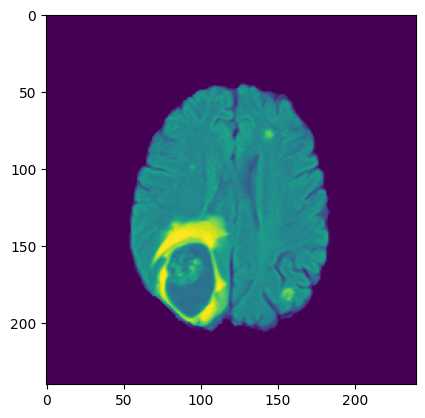

In [175]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_slices_tfrecords/all_pats_single_slice_gray/00172/00172_2.tfrecord"
rgb = False

num_images = 5 # 4 sequences + 1 mask

image_shape = []

if rgb: # rgb images need three channels
    image_shape = [240, 240, 3, num_images]
else: # gray scale images don't
    image_shape = [240, 240, num_images]

feature_description = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "sex": tf.io.FixedLenFeature([], tf.int64, default_value=[0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "layer": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, image_shape) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["layer"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, layer, primary in test_image:
    print(f"Sex: {sex.numpy()}")
    print(f"Age: {age.numpy()}")
    print(f"Layer: {layer.numpy()}")
    print(f"Primary: {primary.numpy()}")
    numpy_image = image.numpy()
    print(numpy_image.shape)
    # print max and min values
    print(f"Median value: {np.median(numpy_image)}")
    plt.imshow(numpy_image[:,:,3])

# sex
# m = 1, 0
# f = 0, 1

### Dataset Visualisation

In [40]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------
# 1) Label -> name mapping
#    (adjust names if your paper uses different wording)
# ---------------------------
yale_label_to_name = {
    1: "Lung cancer",
    2: "Melanoma",
    3: "Breast cancer",
    4: "Renal cell cancer",
    5: "Gastrointestinal cancer",
}


# ---- Choose which channel is T1c in your stack ----
# Most common order is [T1, T1c, T2, FLAIR, ...]
T1C_CHANNEL_INDEX = 1   # <- change if your stack order differs

def pick_t1c(img):
    """Return a 2D image for plotting (T1c if multi-channel)."""
    img = np.asarray(img)

    # If already 2D: done
    if img.ndim == 2:
        return img

    # If HxWxC: take T1c channel
    if img.ndim == 3:
        c = img.shape[-1]
        if c >= 2:
            idx = min(T1C_CHANNEL_INDEX, c - 1)
            return img[..., idx]
        return img[..., 0]

    # If something unexpected: squeeze to 2D as best effort
    return np.squeeze(img)


def pick_mask(mask, fallback_from_img=None):
    """Return a 2D binary-ish mask if available."""
    if mask is not None:
        m = np.asarray(mask)
        if m.ndim == 3:
            m = m[..., 0]
        m = (m > 0).astype(np.uint8)
        return m

    # Optional fallback: if mask wasn't extracted but last channel might be a mask
    if fallback_from_img is not None:
        arr = np.asarray(fallback_from_img)
        if arr.ndim == 3 and arr.shape[-1] >= 2:
            maybe = arr[..., -1]
            uniq = np.unique(maybe)
            if len(uniq) <= 10:  # heuristic: mask-like
                return (maybe > 0).astype(np.uint8)

    return None


def label_to_text(lbl: int) -> str:
    return f"{yale_label_to_name.get(int(lbl), 'Unknown')}"


# ---------------------------
# 2) Helper to robustly extract image + mask from your lesion object
#    Works for common patterns:
#    - dict with keys like 'image'/'mask'
#    - tuple/list where last/second element is the mask
#    - multi-channel arrays (mask in last channel)
# ---------------------------
def _to_2d(arr):
    arr = np.asarray(arr)
    if arr.ndim == 3 and arr.shape[-1] in (1, 3, 4):
        # if HxWxC -> take first channel for grayscale view
        return arr[..., 0]
    return arr

def extract_image_and_mask(lesion_obj):
    img, msk = None, None

    # dict-like
    if isinstance(lesion_obj, dict):
        for k in ["image", "img", "x", "slice"]:
            if k in lesion_obj:
                img = lesion_obj[k]
                break
        for k in ["mask", "msk", "y_mask", "seg", "segmentation"]:
            if k in lesion_obj:
                msk = lesion_obj[k]
                break
        if img is None:
            # fall back: first array-like value
            for v in lesion_obj.values():
                if hasattr(v, "shape"):
                    img = v
                    break

    # list/tuple-like (your code suggests lesion[3] is the image)
    elif isinstance(lesion_obj, (list, tuple)):
        # your existing usage: yale_test_leasions[0][3]
        if len(lesion_obj) > 3 and hasattr(lesion_obj[3], "shape"):
            img = lesion_obj[3]

        # try to find a mask candidate in the remaining entries
        # (common: last element is mask, or a separate array with same HxW)
        candidates = [x for x in lesion_obj if hasattr(x, "shape")]
        if img is None and len(candidates) > 0:
            img = candidates[0]
        if img is not None:
            img2d = _to_2d(img)
            for c in candidates[::-1]:
                c2d = _to_2d(c)
                if c2d.shape == img2d.shape and not np.array_equal(c2d, img2d):
                    msk = c2d
                    break

    # raw array
    else:
        if hasattr(lesion_obj, "shape"):
            img = lesion_obj

    if img is None:
        raise ValueError("Could not extract an image from lesion object.")

    img2d = _to_2d(img)

    # If image is HxWx2 or HxWx4 etc: try last channel as mask if it looks binary-ish
    if msk is None and np.asarray(img).ndim == 3 and np.asarray(img).shape[-1] >= 2:
        maybe_mask = np.asarray(img)[..., -1]
        # heuristic: many zeros, limited unique values
        uniq = np.unique(maybe_mask)
        if len(uniq) <= 10:
            msk = maybe_mask

    if msk is not None:
        msk = _to_2d(msk)
        # binarize gently (handles 0/1 or 0/255)
        msk = (msk > 0).astype(np.uint8)

    return img2d, msk


# ---------------------------
# 3) Collect 9 random examples across the dataset
#    Uses your prepare_2d_images(...) so you see the *same* preprocessing.
# ---------------------------
def sample_yale_examples(
    n=9,
    save_as_rgb=False,
    save_as_cutout=False,
    include_mask=True,
    seed=0,
):
    rng = random.Random(seed)

    patients = [
        p for p in os.listdir(path_to_yale_met_slices)
        if os.path.isdir(os.path.join(path_to_yale_met_slices, p))
    ]

    # keep only those that exist in your label dict
    patients = [p for p in patients if p in yale_specific_primaries_dict]
    rng.shuffle(patients)

    examples = []
    for pid in patients:
        # your pipeline function (already in your notebook/scripts)
        lesions, lesion_layers = prepare_2d_images(
            patient_id=pid,
            path_to_sliced_images=path_to_yale_met_slices,
            include_mask=include_mask,
            only_cutout=save_as_cutout,
            save_as_rgb=save_as_rgb,
            dataset="Yale"
        )

        y = int(yale_specific_primaries_dict[pid])

        for li, lesion_obj in enumerate(lesions):
            img2d, msk2d = extract_image_and_mask(lesion_obj)

            # optional: layer info if you want it in the title
            layer = lesion_layers[li] if li < len(lesion_layers) else None

            examples.append({
                "patient_id": pid,
                "lesion_idx": li,
                "layer": layer,
                "y": y,
                "img": img2d,
                "mask": msk2d,
            })
            if len(examples) >= n:
                return examples

    return examples


# ---------------------------
# 4) Plot 3x3 grids
#    A) without segmentation
#    B) with segmentation overlay (and contour)
# ---------------------------

def plot_grid_no_mask(examples, suptitle="Yale examples (no segmentation)"):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, ex in zip(axes, examples):
        img2d = pick_t1c(ex["img"])
        ax.imshow(img2d, cmap="gray")
        ax.set_title(label_to_text(ex["y"]), fontsize=11)
        ax.axis("off")

    for ax in axes[len(examples):]:
        ax.axis("off")

    plt.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_grid_with_mask(
    examples,
    suptitle="Yale examples (segmentation highlighted)"
):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, ex in zip(axes, examples):
        # --- Base image (T1c) ---
        img2d = pick_t1c(ex["img"])
        ax.imshow(img2d, cmap="gray")

        # --- Segmentation mask ---
        m = pick_mask(ex.get("mask", None), fallback_from_img=ex["img"])
        if m is not None:
            # Light blue overlay (only where mask == 1)
            ax.imshow(
                np.ma.masked_where(m == 0, m),
                cmap="cool",
                alpha=0.35
            )

            # Crisp border around lesion
            ax.contour(
                m,
                levels=[0.5],
                colors=["#4FA3E3"],  # slightly stronger blue for border
                linewidths=1.0
            )

        # --- Title (class name only) ---
        ax.set_title(label_to_text(ex["y"]), fontsize=11)
        ax.axis("off")

    # Hide unused axes if <9 examples
    for ax in axes[len(examples):]:
        ax.axis("off")

    # adjust font to be serif
    plt.rcParams['font.family'] = 'serif'

    plt.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()


In [34]:
def sample_yale_examples_one_per_primary_unique_patient(
    n=9,
    save_as_rgb=False,
    save_as_cutout=False,
    include_mask=True,
    seed=42,
):
    """
    Returns up to n examples with:
      - unique patients only
      - at least one example per primary (until grid is full)

    Note: If you have >n primaries present, you can only show n of them in a 3x3 grid.
    """
    rng = random.Random(seed)

    # --- Build patient list from filesystem and label dict intersection ---
    patients_fs = [
        p for p in os.listdir(path_to_yale_met_slices)
        if os.path.isdir(os.path.join(path_to_yale_met_slices, p))
    ]
    patients = [p for p in patients_fs if p in yale_specific_primaries_dict]

    # --- Group patients by primary label ---
    label_to_patients = {}
    for pid in patients:
        y = int(yale_specific_primaries_dict[pid])
        label_to_patients.setdefault(y, []).append(pid)

    # shuffle each group for randomness but reproducibility
    for y in label_to_patients:
        rng.shuffle(label_to_patients[y])

    # --- Step 1: pick one unique patient per label (until we hit n) ---
    # Use a stable label order for nicer reproducibility in figures
    label_order = [k for k in yale_label_to_name.keys() if k in label_to_patients]  # preferred order
    label_order += [k for k in sorted(label_to_patients.keys()) if k not in label_order]

    selected_patients = []
    used_patients = set()

    for y in label_order:
        if len(selected_patients) >= n:
            break
        if len(label_to_patients[y]) == 0:
            continue

        pid = label_to_patients[y].pop(0)
        if pid not in used_patients:
            selected_patients.append((pid, y))
            used_patients.add(pid)

    # --- Step 2: fill remaining slots with unused patients (balanced-ish round-robin) ---
    if len(selected_patients) < n:
        # collect remaining patients per label excluding used
        remaining = {y: [p for p in ps if p not in used_patients] for y, ps in label_to_patients.items()}
        for y in remaining:
            rng.shuffle(remaining[y])

        # round-robin over labels until full or exhausted
        while len(selected_patients) < n:
            added_any = False
            for y in label_order:
                if len(selected_patients) >= n:
                    break
                if y in remaining and remaining[y]:
                    pid = remaining[y].pop(0)
                    if pid not in used_patients:
                        selected_patients.append((pid, y))
                        used_patients.add(pid)
                        added_any = True
            if not added_any:
                break  # no more patients available

    # --- Convert selected patients into examples (one lesion per patient) ---
    examples = []
    for pid, y in selected_patients:
        lesions, lesion_layers = prepare_2d_images(
            patient_id=pid,
            path_to_sliced_images=path_to_yale_met_slices,
            include_mask=include_mask,
            only_cutout=save_as_cutout,
            save_as_rgb=save_as_rgb,
            dataset="Yale"
        )

        if len(lesions) == 0:
            continue

        # choose one lesion per patient (random). If you want "first lesion", set idx = 0
        idx = rng.randrange(len(lesions))
        lesion_obj = lesions[idx]
        layer = lesion_layers[idx] if idx < len(lesion_layers) else None

        img2d, msk2d = extract_image_and_mask(lesion_obj)

        examples.append({
            "patient_id": pid,
            "lesion_idx": idx,
            "layer": layer,
            "y": y,
            "img": img2d,
            "mask": msk2d,
        })

        if len(examples) >= n:
            break

    return examples


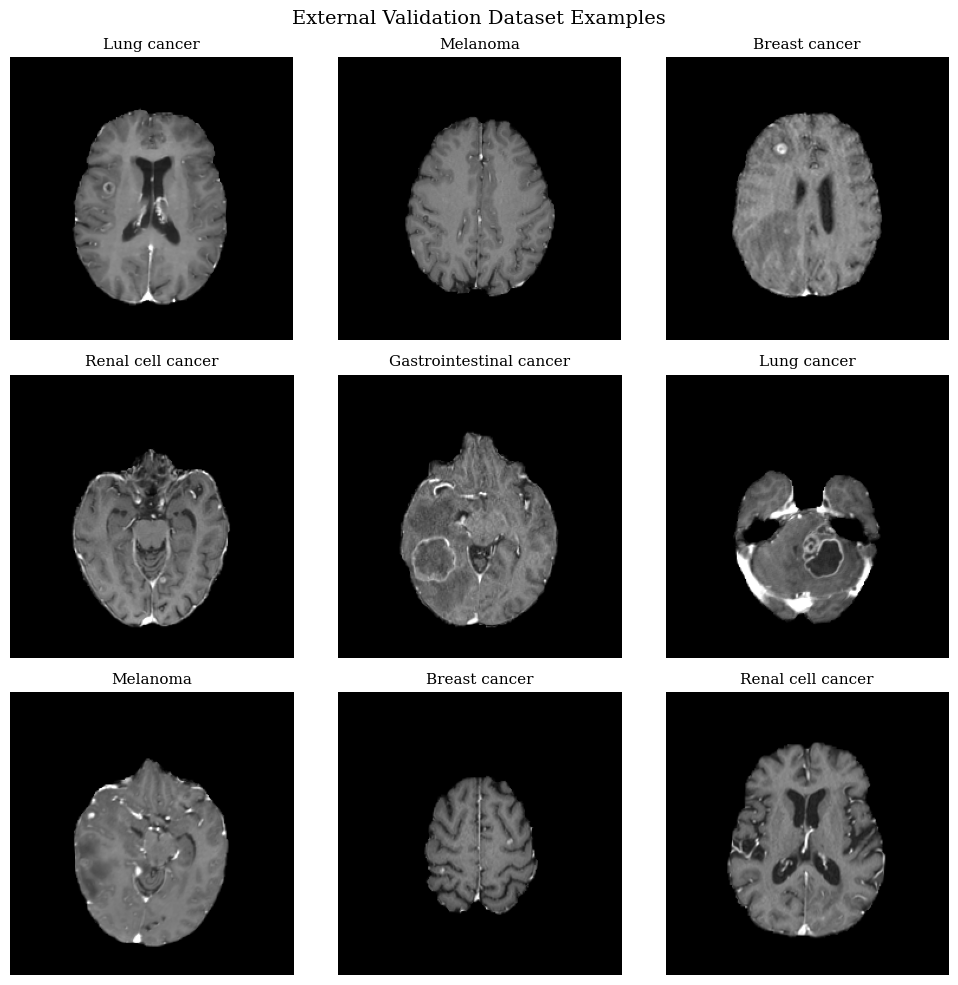

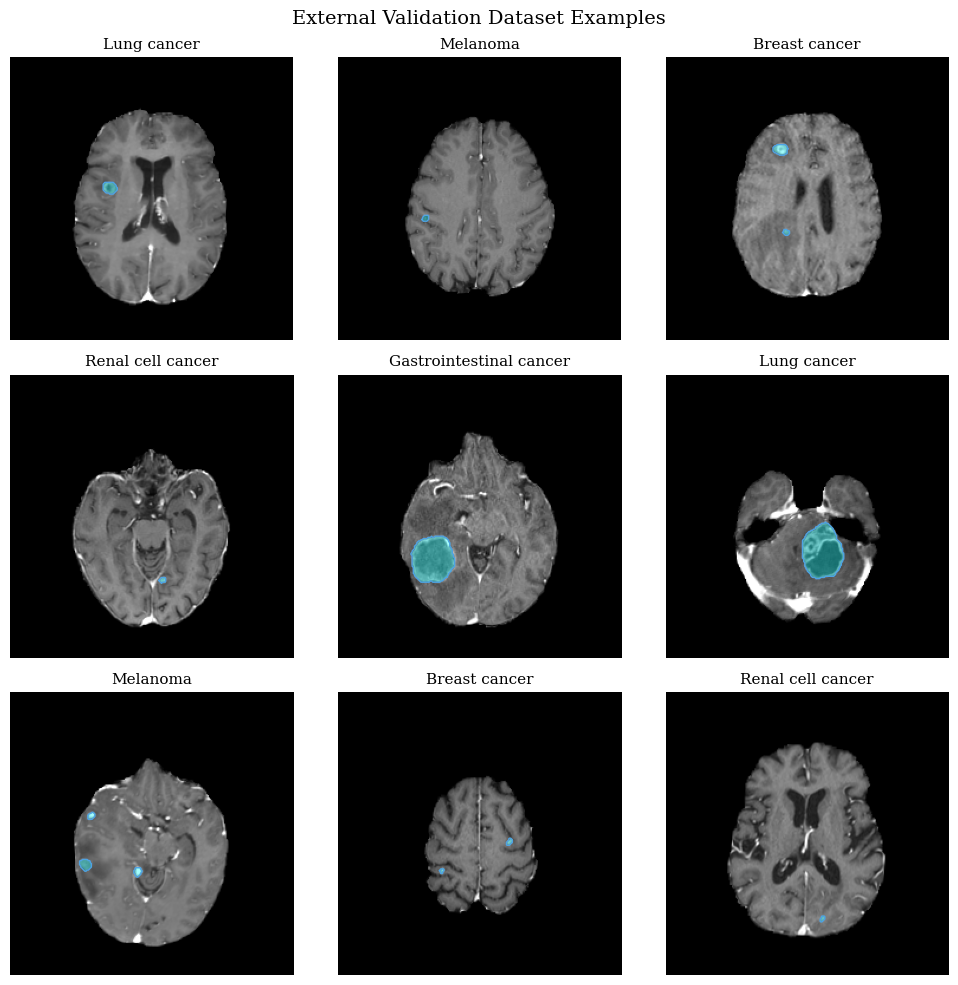

In [47]:
examples = sample_yale_examples_one_per_primary_unique_patient(
    n=9,
    save_as_rgb=False,
    save_as_cutout=False,
    include_mask=True,
    seed=42
)

plot_grid_no_mask(examples, suptitle="External Validation Dataset Examples")
plot_grid_with_mask(examples, suptitle="External Validation Dataset Examples")


### Lesion summary

In [50]:
import tensorflow as tf
import os
import pandas as pd
from collections import Counter

image_shape = [240, 240, 5]

feature_description = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "sex": tf.io.FixedLenFeature([], tf.int64, default_value=[0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "layer": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse_tfrecord_primary(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    return parsed["primary"]


# TFRecord root folder
tfrecord_root = path_to_yale_tfrecords / "all_pats_single_slice_gray"


def count_lesions_and_class_distribution(tfrecord_root):
    tfrecord_files = []

    for root, _, files in os.walk(tfrecord_root):
        for f in files:
            if f.endswith(".tfrecord"):
                tfrecord_files.append(os.path.join(root, f))

    print(f"Found {len(tfrecord_files)} TFRecord files")

    primary_counter = Counter()

    dataset = tf.data.TFRecordDataset(
        tfrecord_files,
        compression_type="GZIP"
    )

    for raw_example in dataset:
        primary = parse_tfrecord_primary(raw_example).numpy()
        primary_counter[int(primary)] += 1

    total_lesions = sum(primary_counter.values())

    return total_lesions, primary_counter


total_lesions, primary_counter = count_lesions_and_class_distribution(
    tfrecord_root
)

print(f"\nTotal number of lesions used: {total_lesions}\n")

df = pd.DataFrame.from_dict(
    primary_counter,
    orient="index",
    columns=["lesion_count"]
).sort_index()

df["percentage"] = 100 * df["lesion_count"] / total_lesions

# Optional: add class names for readability
df["class_name"] = df.index.map(
    lambda x: yale_label_to_name.get(x, f"Unknown ({x})")
)

df = df[["class_name", "lesion_count", "percentage"]]

# Pretty printing
df["percentage"] = df["percentage"].map(lambda x: f"{x:.2f}%")

print(df)


Found 681 TFRecord files

Total number of lesions used: 680

                class_name  lesion_count percentage
1              Lung cancer           282     41.47%
2                 Melanoma           206     30.29%
3            Breast cancer           129     18.97%
4        Renal cell cancer            28      4.12%
5  Gastrointestinal cancer            35      5.15%


2025-12-15 19:29:29.510834: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
